In [1]:
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

d:\Python\aox\enzyme-mining-aox


In [2]:
DATADIR = os.path.join(CURRENT_DIR, "data", "aox")
filenames = {
    # download or curate from the database website
    "brenda_sequence": join(DATADIR, "raw", "brenda_sequence.tsv"),
    "brenda_reference": join(DATADIR, "raw", "brenda_reference.tsv"),
    "brenda_organism": join(DATADIR, "raw", "brenda_organism.tsv"),
    "uniprot_sequence": join(DATADIR, "raw", "uniprot_sequence.tsv"),
    "pubmed": join(DATADIR, "raw", "pubmed.tsv"),

    # manual curate from literature
    "organism": join(DATADIR, "raw", "organisms.txt"),
    "known_sequence": join(DATADIR, "raw", "known_sequence.tsv"),
    "sequence_fasta": join(DATADIR, "raw", "sequence.fasta"),
}

dirnames = {
    # 
    "raw_sequence": join(DATADIR, "raw", "sequence"),
}

CACHEDIR = join(DATADIR, "cache") # for sequence mining and analysis
RESULTDIR = join(DATADIR, "result") # for the publication data

## 1. Sequence data

### 1.1 Sequence data

the sequence data in Brenda database

In [3]:
ec_uniprot = pd.read_csv(filenames['brenda_sequence'], sep="\t")
ec_uniprot = ec_uniprot[[ec_uniprot.columns[i] for i in [0,1,2,3,]]]
ec_uniprot.rename(columns={
    col:col.strip() for col in ec_uniprot.columns
}, inplace=True)
ec_uniprot["UNIPROT"] = ec_uniprot["UNIPROT"].apply(lambda x: x.split(" ")[0])
print(ec_uniprot.shape) # Totally 107 sequences
ec_uniprot.head()

(107, 4)


,UNIPROT,ENTRY NAME,ORGANISM,NO. OF AA
0,F2QY27,ALOX1_KOMPC,Komagataella phaffii (strain ATCC 76273 / CBS ...,663
1,P04842,ALOX1_KOMPG,Komagataella phaffii (strain GS115 / ATCC 20864),663
2,F2R038,ALOX2_KOMPC,Komagataella phaffii (strain ATCC 76273 / CBS ...,663
3,C4R702,ALOX2_KOMPG,Komagataella phaffii (strain GS115 / ATCC 20864),663
4,Q00922,ALOX_CANBO,Candida boidinii,663


In [4]:
uniprot_ec = pd.read_csv(filenames['uniprot_sequence'], sep="\t")
print(uniprot_ec.shape) # Totally 104 sequences
uniprot_ec.head(2)

(104, 11)


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,EC number,Sequence,PubMed ID,Annotation
0,P04842,reviewed,ALOX1_KOMPG,Alcohol oxidase 1 (AO 1) (AOX 1) (EC 1.1.3.13)...,AOX1 PAS_chr4_0821,Komagataella phaffii (strain GS115 / ATCC 2086...,663,1.1.3.13,MAIPEEFDILVLGGGSSGSCIAGRLANLDHSLKVGLIEAGENNLNN...,3889590; 19465926; 1882546; 9396748,5.0
1,F2QY27,reviewed,ALOX1_KOMPC,Alcohol oxidase 1 (AO 1) (AOX 1) (EC 1.1.3.13)...,AOX1 PP7435_Chr4-0130,Komagataella phaffii (strain ATCC 76273 / CBS ...,663,1.1.3.13,MAIPEEFDILVLGGGSSGSCIAGRLANLDHSLKVGLIEAGENNLNN...,2660463; 21575661; 27388471; 2657390; 9396748,4.0


Checking the differences between the two databases

In [5]:
print("Brenda - UniProt:")
print(set(ec_uniprot['ENTRY NAME']) - set(uniprot_ec['Entry Name']))
print()

print("UniProt - Brenda")
print(set(uniprot_ec['Entry Name']) - set(ec_uniprot['ENTRY NAME']))

Brenda - UniProt:
{'VAOX_PENSI', 'T2M2J4_PHACH', 'G8ZNE6_TORDC', 'CHOX_ARTGO', 'Q7WZ62_9ACTN', 'E3QHV8_COLGM'}

UniProt - Brenda
{'G8ZNE6_TORDE', 'A0A9Q8V9V0_9HYPO', 'A0A977TIR6_PHACH'}


### 1.2 Reference Data

In [6]:
ec_reference = pd.read_csv(filenames['brenda_reference'], sep='\t')
ec_reference.rename(columns={
    col: col.strip() for col in ec_reference.columns
}, inplace=True)
pubmed_reference = set(ec_reference['PUBMED ID'])
print(len(pubmed_reference)) # 64 references in Brenda database
ec_reference.head(2)

64


,REF,AUTHORS,TITLE,JOURNAL,VOL.,PAGES,YEAR,ORGANISM (UNIPROT),PUBMED ID,SOURCE
0,484905,"Janssen, F.W.; Ruelius, H.W.","Alcohol oxidase, a flavoprotein from several B...",Biochim. Biophys. Acta,151,330-342,1968,Basidiomycota,5636370,Manually annotated by BRENDA team
1,484906,"Janssen, F.W.; Kerwin, R.M.; Ruelius, H.W.",Alcohol oxidase from basidiomycetes,Methods Enzymol.,41B,364-369,1975,"Basidiomycota, Polyporus obtusus, Radulodon ca...",236460,Manually annotated by BRENDA team


In [7]:
uniprot_pids = []
for l in [ str(pids).split("; ") for pids in uniprot_ec['PubMed ID']]:
    uniprot_pids.extend(l)
set_uniprot_pids = set(uniprot_pids)
set_uniprot_pids.remove('nan')
print(len(set_uniprot_pids)) # 35 references in UniProt database

35


Obtain basic information about the literature in the pubmed database using `pymed`.

In [8]:
import time
from pymed import PubMed
pubmed_path = filenames["pubmed"]
if not os.path.exists(pubmed_path):
    pubmed = PubMed(tool="MyTool", email="my@email.address")
    data = []
    for query in set_uniprot_pids:
        print(query)
        time.sleep(2)
        try:
            results = pubmed.query(query, max_results=1)
            for r in results:
                pids = r.pubmed_id.split('\n')
                if query in pids:
                    pid = query
                else:
                    pid = pids[0]
                if r.publication_date.year:
                    year = r.publication_date.year
                else:
                    year = 0
                data.append([query, r.title, r.abstract, year, r.doi, pid])
        except:
            print("Something error.")
    reference_uniprot = pd.DataFrame(data, columns = ["query", "title", "abstract", "year", "doi", "pubmed id"])

    reference_uniprot["doi"] = reference_uniprot["doi"].str.replace("\n", " ")
    reference_uniprot["abstract"] = reference_uniprot["abstract"].str.replace("\n", " ")
    reference_uniprot.sort_values(by="year").to_csv(pubmed_path, sep="\t", index=False)
else:
    reference_uniprot = pd.read_csv(pubmed_path, sep="\t")

UniProt Sequences evidenced by Brenda references

In [9]:
uniprot_ec['Evidence Brenda'] = uniprot_ec['PubMed ID'].apply(lambda x: np.any([pid in pubmed_reference for pid in str(x).split("; ")]))
print(uniprot_ec[uniprot_ec['Evidence Brenda'] == True].shape[0]) # 18 sequences
uniprot_ec[uniprot_ec['Evidence Brenda'] == True]['PubMed ID'].unique() # 3 references
# ['1770353', '17476699', '17660304']

18


array(['2582370; 2002763; 1770353; 1882546; 8873445', '17476699',
       '17660304'], dtype=object)

The corresponding brenda literature ID (REF).

In [10]:
ec_reference[ec_reference['PUBMED ID'].isin(['1770353', '17476699', '17660304'])]
# [484915, 684565, 690209]

,REF,AUTHORS,TITLE,JOURNAL,VOL.,PAGES,YEAR,ORGANISM (UNIPROT),PUBMED ID,SOURCE
10,484915,"Bystryck, L.V.; Dijkhuizen, L.; Harder, W.",Modification of flavin adenine dinucleotide in...,J. Gen. Microbiol.,137,2381-2386,1991,"[Candida] boidinii, Ogataea angusta, Komagatae...",1770353,Manually annotated by BRENDA team
37,684565,"Daniel, G.; Volc, J.; Filonova, L.; Plihal, O....",Characteristics of Gloeophyllum trabeum alcoho...,Appl. Environ. Microbiol.,73,6241-6253,2007,"Gloeophyllum trabeum (A8DPS4), Gloeophyllum tr...",17660304,Manually annotated by BRENDA team
49,690209,"Ito, T.; Fujimura, S.; Uchino, M.; Tanaka, N.;...","Distribution, diversity and regulation of alco...",Yeast,24,523-532,2007,"[Candida] sonorensis (A5LGD9), [Candida] sonor...",17476699,Manually annotated by BRENDA team


Related organisms

In [11]:
pid2orgs = {}
for pid, orgs in zip(ec_reference['PUBMED ID'], ec_reference['ORGANISM (UNIPROT)']):
    if not pid in pid2orgs.keys():
        pid2orgs[pid] = [ org.strip().split('(')[0].strip() for org in orgs.split(',')]
    else:
        pid2orgs[pid] += [ org.strip().split('(')[0].strip() for org in orgs.split(',')]

In [12]:
orgs = []
for _orgs in pid2orgs.values():
    orgs.extend(_orgs)
orgs_reference = set(orgs)

The sequences evidenced by Brenda Reference

In [13]:
uniprot_ec_filtered_by_reference = uniprot_ec[(uniprot_ec['Evidence Brenda'] == True)]
print(uniprot_ec_filtered_by_reference.shape[0]) # 18 sequences
uniprot_ec_filtered_by_reference[["Entry", "Entry Name", "Organism", "Length"]]


18


,Entry,Entry Name,Organism,Length
3,P04841,ALOX_PICAN,Pichia angusta (Yeast) (Hansenula polymorpha),664
39,A5LGD9,A5LGD9_9ASCO,[Candida] sonorensis,656
40,A5LGE1,A5LGE1_9ASCO,Ogataea pignaliae,639
41,A5LGE2,A5LGE2_9ASCO,Ogataea pignaliae,656
75,A5LGE0,A5LGE0_9ASCO,[Candida] sonorensis,423
76,A5LGE3,A5LGE3_9ASCO,Ogataea methylovora,238
77,A5LGE4,A5LGE4_9ASCO,Ogataea minuta,249
78,A5LGE5,A5LGE5_9ASCO,[Candida] methanosorbosa,252
79,A5LGE6,A5LGE6_9ASCO,[Candida] succiphila,253
80,A5LGE7,A5LGE7_9ASCO,Kuraishia capsulata,248


18 sequences were supported by Brenda's literature, however, 13 of them were too short in length.

Related sequences

In [14]:
uniprot_ec['Evidence(Organism) Brenda'] = uniprot_ec['Organism'].apply(lambda x: x.split('(')[0].strip() in orgs_reference)
uniprot_ec_filtered_by_organism = uniprot_ec[(uniprot_ec['Evidence(Organism) Brenda'] == True) & (uniprot_ec['Evidence Brenda'] == False)]
print(uniprot_ec_filtered_by_organism.shape[0])
uniprot_ec_filtered_by_organism[["Entry", "Entry Name", "Organism", "Length"]]


14


,Entry,Entry Name,Organism,Length
0,P04842,ALOX1_KOMPG,Komagataella phaffii (strain GS115 / ATCC 2086...,663
1,F2QY27,ALOX1_KOMPC,Komagataella phaffii (strain ATCC 76273 / CBS ...,663
2,F2R038,ALOX2_KOMPC,Komagataella phaffii (strain ATCC 76273 / CBS ...,663
5,C4R702,ALOX2_KOMPG,Komagataella phaffii (strain GS115 / ATCC 2086...,663
6,A0A024FB95,A0A024FB95_STABO,Starmerella bombicola (Yeast) (Candida bombicola),681
8,A0A067YIW8,A0A067YIW8_9ASCO,Ogataea thermomethanolica (nom. inval.),663
14,A0A1B2JBK5,A0A1B2JBK5_PICPA,Komagataella pastoris (Yeast) (Pichia pastoris),663
15,A0A1B2JII2,A0A1B2JII2_PICPA,Komagataella pastoris (Yeast) (Pichia pastoris),663
38,A0A977TIR6,A0A977TIR6_PHACH,Phanerodontia chrysosporium (White-rot fungus)...,653
50,C5MAH1,C5MAH1_CANTT,Candida tropicalis (strain ATCC MYA-3404 / T1)...,378


14 sequences were supported by Brenda's literature related organism. The length of C5MAH1 was too short.

### 1.3 Known sequences

Create the file for each organism to store the fetched sequence from NCBI genbank database.

In [15]:
with open(filenames['organism'], "r") as f:
    for org in f.read().split('\n'):
        org_path = join(dirnames['raw_sequence'], f"{org}.txt")
        if not os.path.exists(org_path):
            with open(org_path, "w") as fo:
                fo.write("")

In [16]:
from Bio import SeqIO
seqs = []
for f in os.listdir(dirnames['raw_sequence']):
    for seqrecord in SeqIO.parse(join(dirnames['raw_sequence'], f), "fasta"):
        seqs.append(seqrecord)
SeqIO.write(seqs, filenames['sequence_fasta'], "fasta")

21

The above is the workflow automatically inferred by data association. Then construct the known sequence library by reading the brenda literature and extracting the sequence information reported therein. It was stored into the `known_sequences` file. There are 22 sequences in total. (1 is duplicate, CDG66232.1 (UXW61383.1))

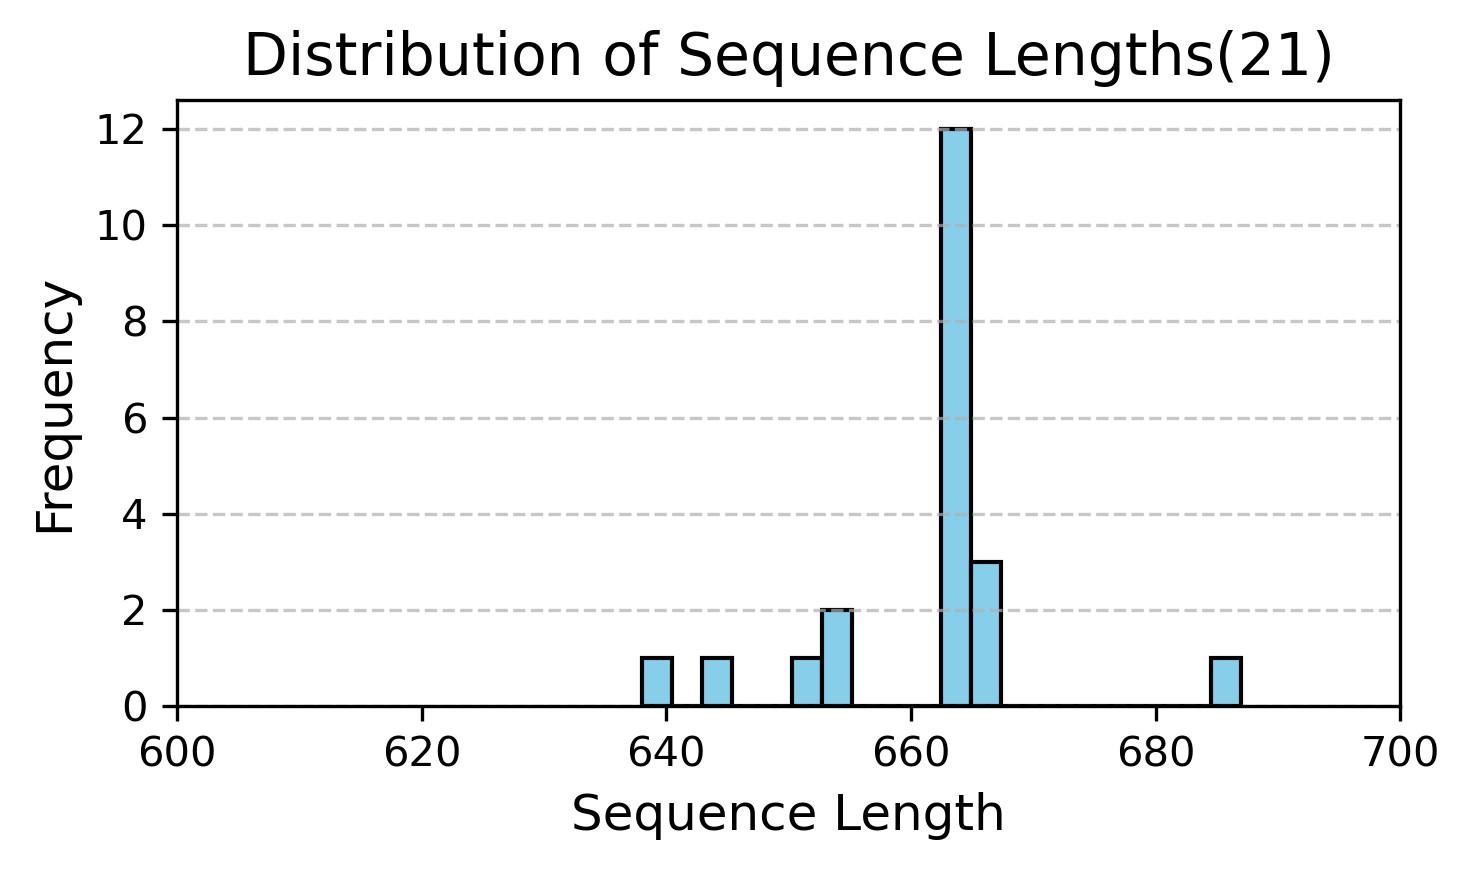

In [17]:

seq_lengths = [len(record.seq) for record in SeqIO.parse(filenames['sequence_fasta'], "fasta")]

# Plot the distribution of sequence lengths
plt.figure(figsize=(5, 3), dpi=300)
plt.hist(seq_lengths, bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribution of Sequence Lengths({len(seq_lengths)})", fontsize=14)
plt.xlabel("Sequence Length", fontsize=12)
plt.xlim((600, 700))
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [55]:
known_sequences = pd.read_csv(filenames["known_sequence"], sep="\t")
known_sequences.head()

# accession for NCBI Genbank ID
# ph for Phylum
# taxid: taxnomony ID in NCBI Taxonomy
# pid for Pubmed ID

,accession,ph,organism,taxid,pid
0,EAA66666.1,Ascomycota,Aspergillus nidulans FGSC A4,227341,23525937
1,AAR89538.1,Ascomycota,Bipolaris victoriae,40125,11056160
2,AAV66467.2,Ascomycota,[Candida] boidinii,5477,16032762
3,AAV66468.1,Ascomycota,[Candida] boidinii,5477,16032762
4,AAF82788.1,Ascomycota,Fulvia fulva,5499,11277434


## 2. Sequence mining

Eliminate similar sequences by first clustering known sequences

`cd-hit -i "./data/aox/raw/sequence.fasta" -o "./data/aox/cache/sequence_cluster.fasta" -c 0.9 -n 5 -T 12 -M 16000 -d 0`

Perform structural comparisons to construct the inputs needed for HMM modeling.

Use T-Coffee's online server with the uploaded sequences and structure `5hsa.pdb`.

`t_coffee -in=sequence_cluster.fasta -mode=expresso -blast=LOCAL -pdb_db=/db/pdb/derived_data_format/blast/2021-11-16/pdb_seqres.fa -pdb=5hsa.pdb -evaluate_mode=t_coffee_slow -output=score_html clustalw_aln fasta_aln score_ascii phylip -maxnseq=150 -maxlen=2500 -case=upper -seqnos=off -outorder=input -run_name=result -multi_core=4 -quiet=stdout`

Download the `result.clustalw_aln` file. Convert the format to `.sto` as input for `hmmbuild`

In [56]:
from Bio import AlignIO
AlignIO.convert(join(CACHEDIR, "result.clustalw_aln"), 'clustal', join(CACHEDIR, "result.sto"), 'stockholm')

1

Build the HMM model.

`hmmbuild ./data/aox/cache/result.hmm ./data/aox/cache/result.sto`

Upload `results.hmm` at [HMMER-online](https://www.ebi.ac.uk/Tools/hmmer/search/phmmer) against the **UniProt Reference Proteomes** database. Then download the results.

In [57]:
import os
import json
import requests

def download_hmmsearch(base_url:str, max_:int, output_dir:str, step:int=1000):
    """
    Downloads JSON data in chunks from the specified base URL and saves them into individual files.

    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for start in range(1, max_, step):
        end = start + step - 1
        if end > max_:
            end = max_

        filename = f"{start}-{end}.json"
        output_path = os.path.join(output_dir, filename)
        if os.path.exists(output_path):
            print(f"All ready {output_path}")
            continue

        # 构建参数字符串
        params = {
            "output": "json",
            "range": f"{start},{end}"
        }

        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()

            with open(output_path, "w") as output_file:
                json.dump(data, output_file, indent=4)

            print(f"Saved data to {output_path}")
        else:
            print(f"Failed to retrieve data for range {start}-{end}. Status code: {response.status_code}")
        # break
    print("Data retrieval and storage completed.")


In [58]:
# Download in batches due to large number of sequences.

# job_id = "604D2B8E-7713-11EE-934A-6C75D2021FDD"
# max_ = 30204 # the total number of the sequences

# download_hmmsearch(
#     base_url = f"https://www.ebi.ac.uk/Tools/hmmer/results/{job_id}/score",
#     max_ = max_,
#     output_dir = join(CACHEDIR, "hmmsearch")
# )

In [59]:
# combine the results

hmmsearch_search = []

folder_path = join(CACHEDIR, "hmmsearch")
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            hmmsearch_search.extend(data["results"]["hits"])


In [60]:
len(hmmsearch_search) # 30204

30204

Extract information and organizing it into a tabular format

In [61]:
extracted_info = []

for item in hmmsearch_search:
    extracted_item = {
        'ph': item['ph'],
        'kg': item['kg'],
        'acc': item['acc'],
        'desc': item['desc'],
        'taxid': str(int(item['taxid'])),
        'score': float(item['score']),
        'bias': float(item['bias']),
        'evalue': float(item['evalue']),
    }
    
    # extract the info of the 'domains' list
    if 'domains' in item and item['domains']:
        domain = item['domains'][0]  # Assuming the list of domains contains at least one dictionary
        extracted_item['bitscore'] = float(domain['bitscore'])
        extracted_item['bias_domain'] = float(domain['bias'])
        extracted_item['cevalue'] = float(domain['cevalue'])
        extracted_item['aliaseq'] = domain['aliaseq']
        extracted_item['alisqfrom'] = domain['alisqfrom']
        extracted_item['alisqto'] = domain["alisqto"]
        extracted_item['aliId'] = float(domain['aliId'])
        extracted_item['aliSim'] = float(domain['aliSim'])
    
    extracted_info.append(extracted_item)

df_hmmsearch = pd.DataFrame(extracted_info).sort_values(by='score', ascending=False).reset_index().drop(columns=["index"])
df_hmmsearch['length'] = df_hmmsearch['alisqto'] - df_hmmsearch['alisqfrom']
df_hmmsearch.to_csv(join(CACHEDIR, "hmmsearch.tsv"), sep='\t', index=False)
df_hmmsearch.head()

,ph,kg,acc,desc,taxid,score,bias,evalue,bitscore,bias_domain,cevalue,aliaseq,alisqfrom,alisqto,aliId,aliSim,length
0,Basidiomycota,Eukaryota,A0A409VB76_9AGAR,Uncharacterized protein,181874,1357.6,15.4,0.0,453.160126,0.04,2.600000e-135,QYDIIFAGGGPCSCIAASRLLNADPNLRILIVEYGSSTENVARHIQ...,11,502,0.421589,0.698574,491
1,Ascomycota,Eukaryota,W1QCJ3_OGAPD,Alcohol oxidase,871575,1312.2,0.0,0.0,1312.030762,0.00,0.000000e+00,MAIPDEFDIIVVGGGSTGCCVAGRLANLDdQNLTVALIEGGENNIN...,1,664,0.772247,0.987934,663
2,Ascomycota,Eukaryota,ALOX1_KOMPG,Alcohol oxidase 1,644223,1305.4,0.0,0.0,1305.187988,0.00,0.000000e+00,MAIPEEFDILVLGGGSSGSCIAGRLANLDHSLKVGLIEAGENNLNN...,1,663,0.769231,0.981900,662
3,Ascomycota,Eukaryota,A0A1E4T6V9_9ASCO,Alcohol oxidase,983967,1297.9,0.0,0.0,1297.710571,0.02,0.000000e+00,MAIPDEFDIIVVGGGSAGCPVAGRLANLDESLTVALIEAGENNVNN...,1,665,0.755656,0.972851,664
4,Ascomycota,Eukaryota,A0A1E4SXY7_9ASCO,Alcohol oxidase,983967,1297.3,0.0,0.0,1297.163940,0.01,0.000000e+00,MAIPDEFDIIVLGGGSTGCAIAGRLGNLDESLTVALIEGGENNINN...,1,664,0.751131,0.977376,663


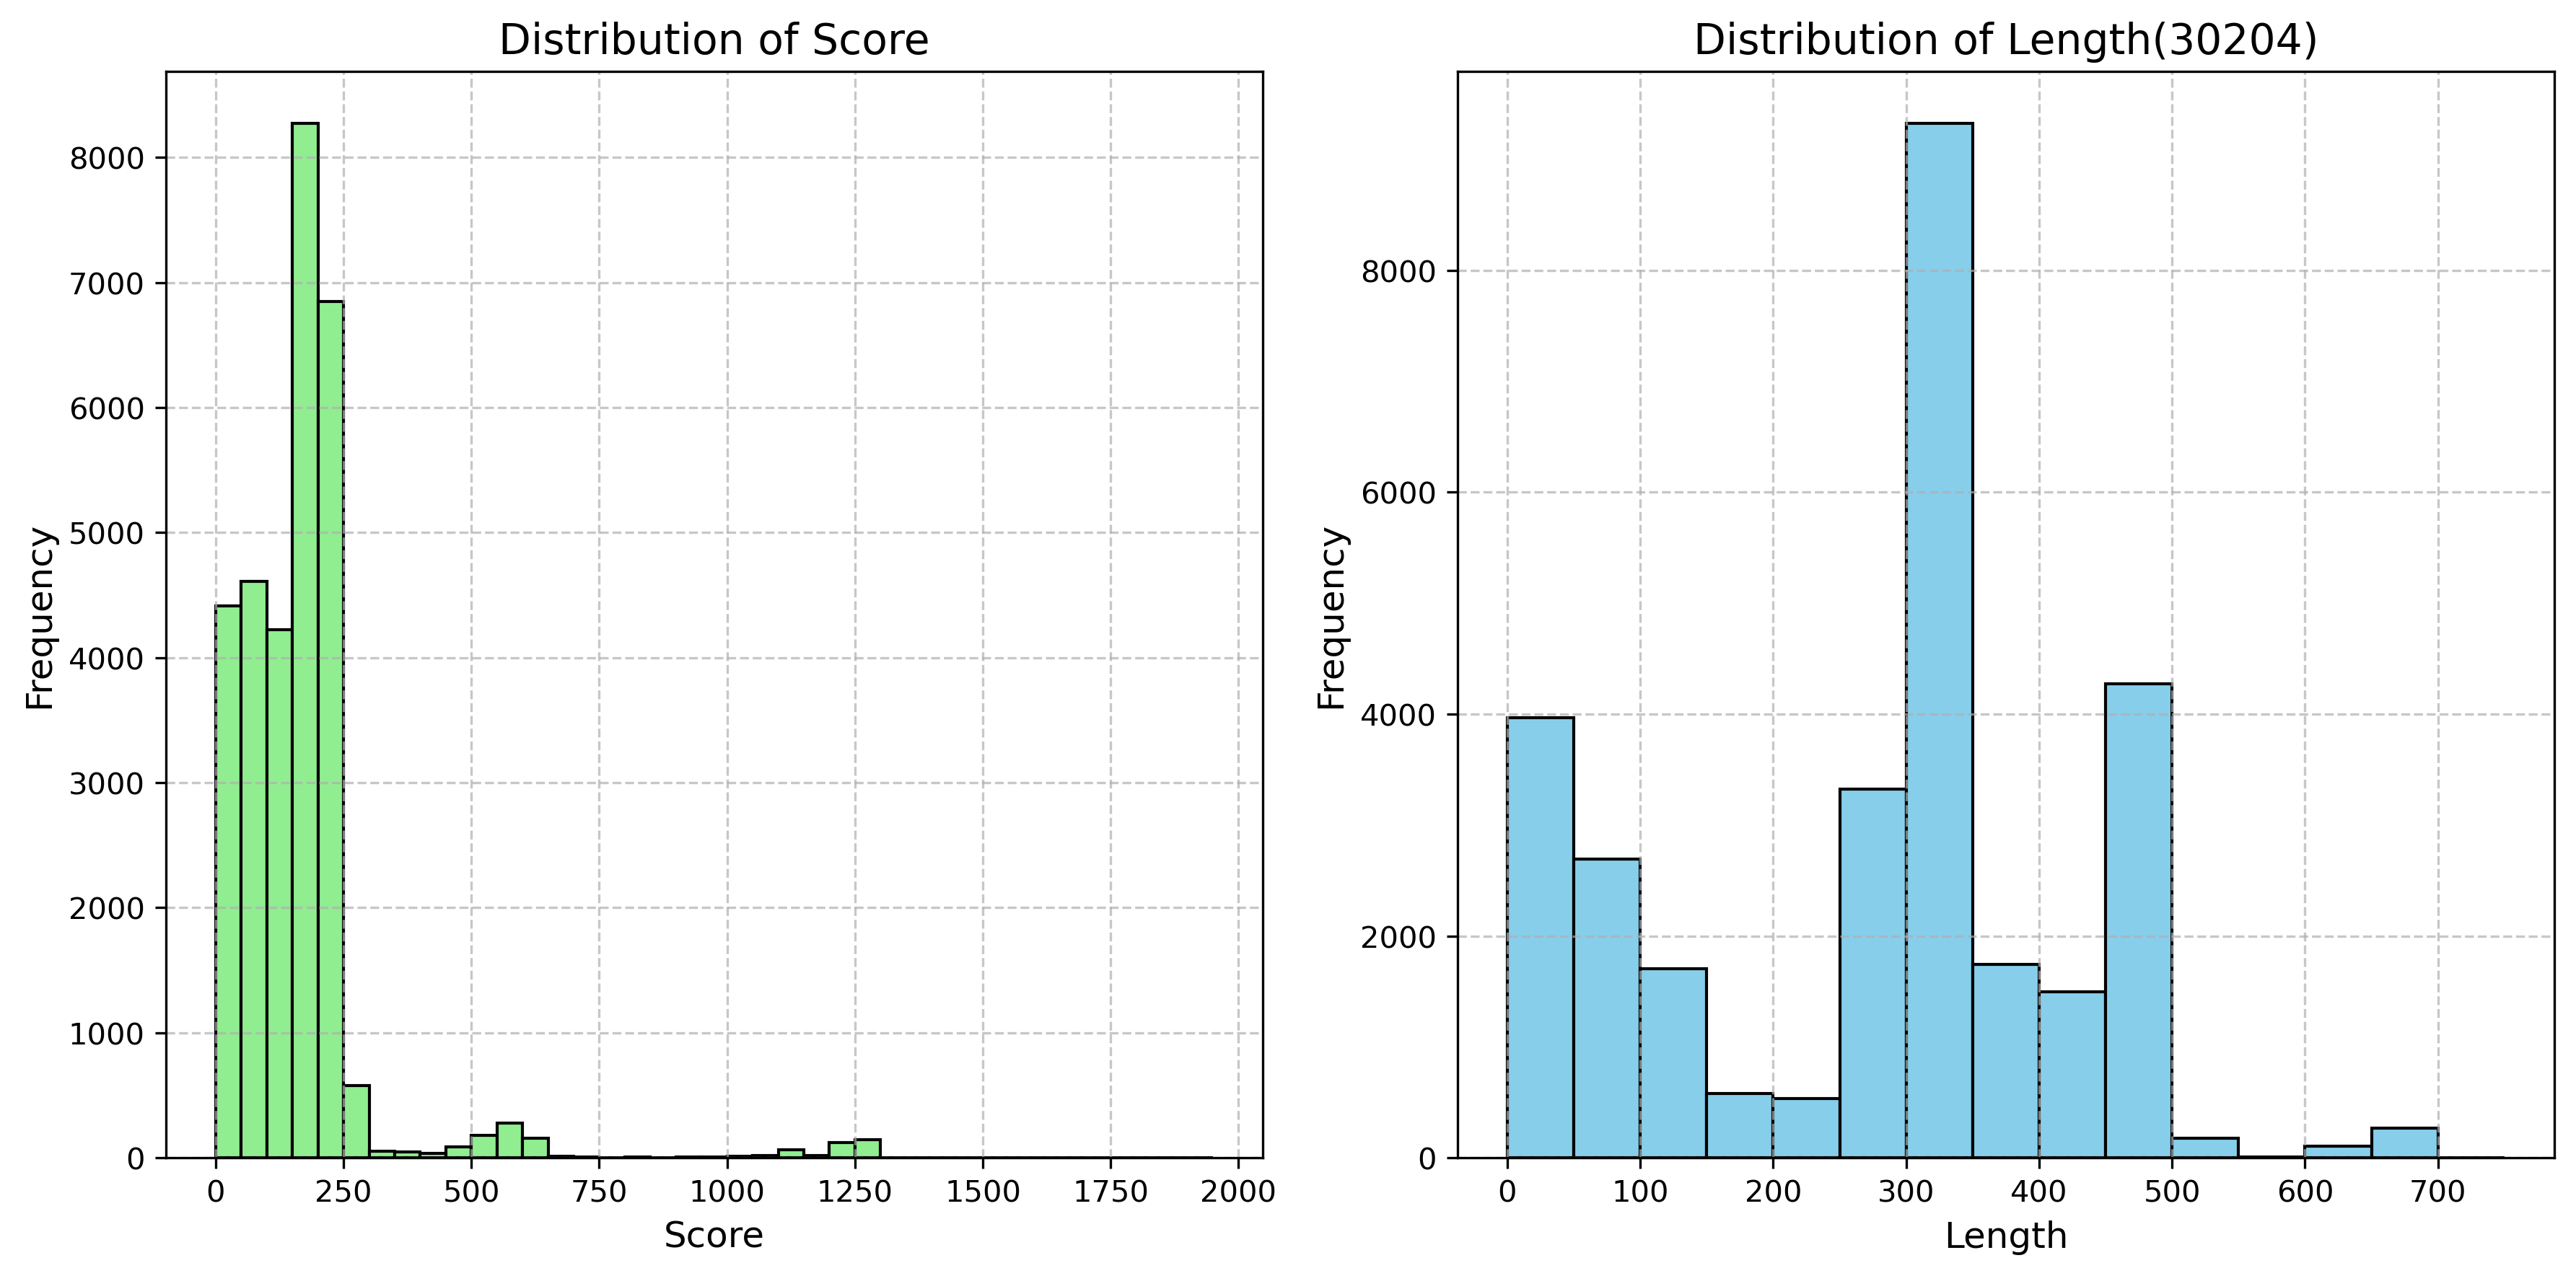

In [62]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Left - score
axes[0].hist(df_hmmsearch['score'], bins=range(0, 2000, 50), color='lightgreen', edgecolor='black')
axes[0].set_title('Distribution of Score', fontsize=14)
axes[0].set_xlabel('Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Right - length
axes[1].hist(df_hmmsearch['length'], bins=range(0, 800, 50), color='skyblue', edgecolor='black')
axes[1].set_title(f'Distribution of Length({len(df_hmmsearch)})', fontsize=14)
axes[1].set_xlabel('Length', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()


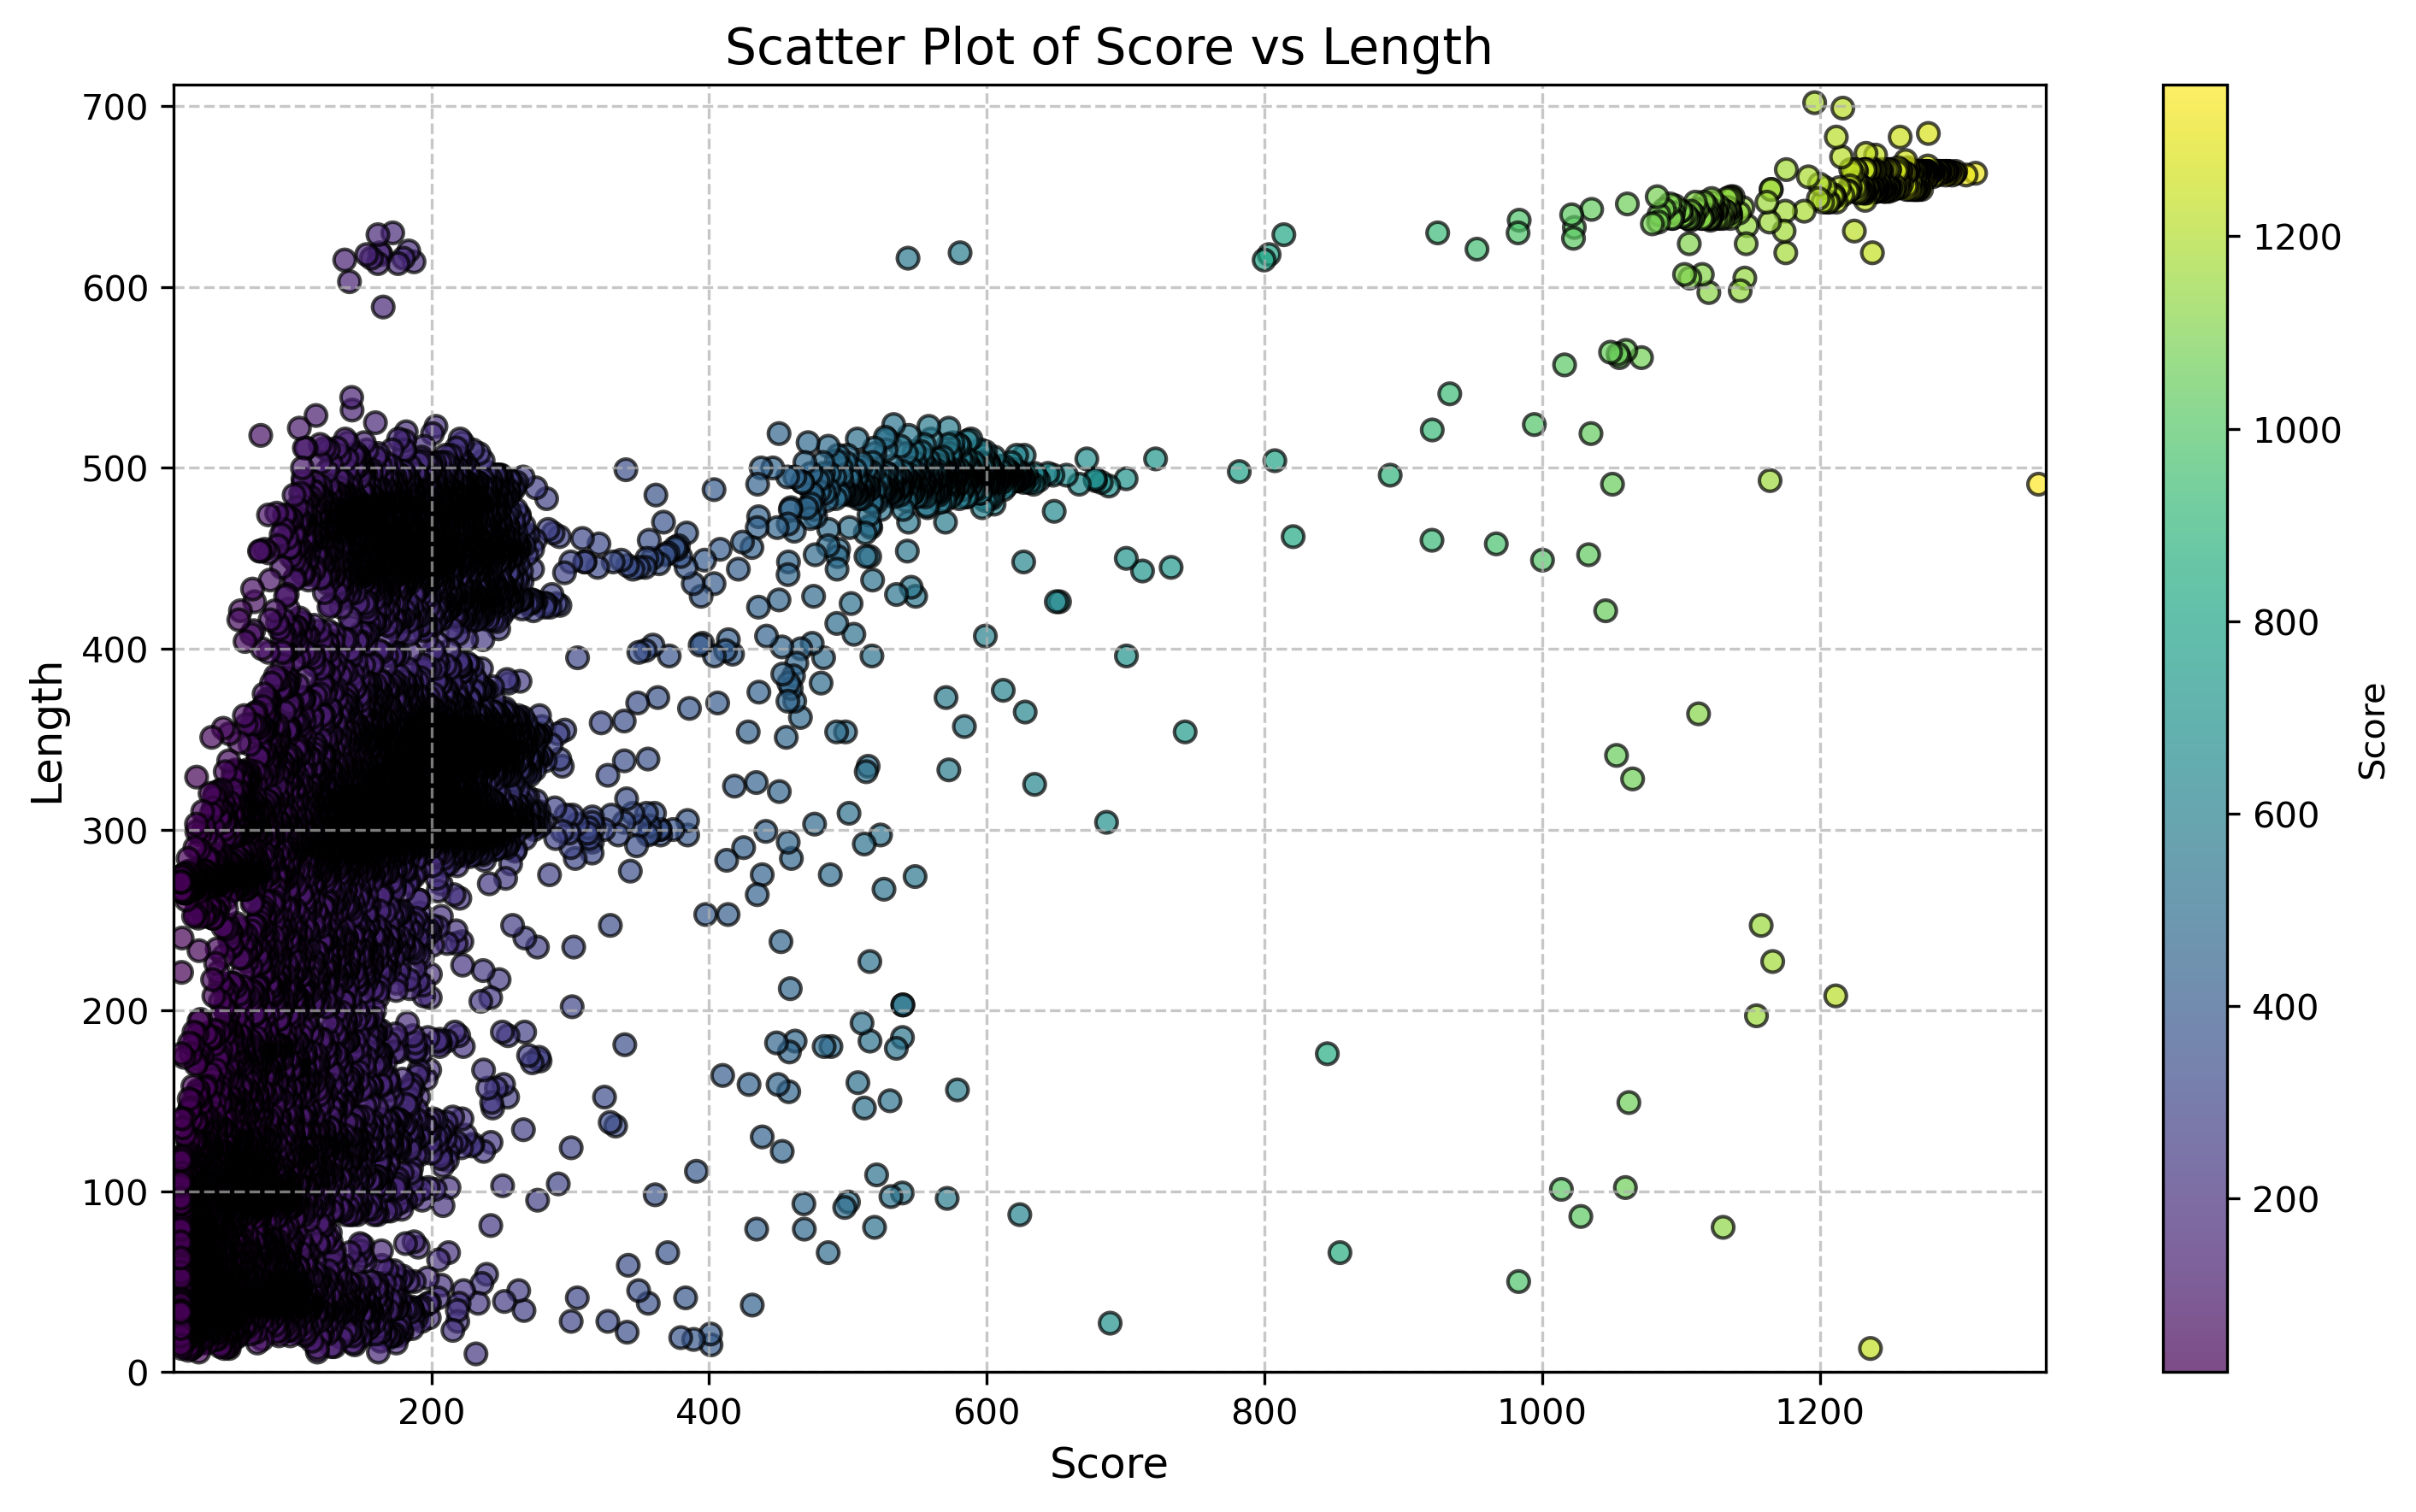

In [63]:
plt.figure(figsize=(10, 6), dpi=300)
scatter = plt.scatter(
    df_hmmsearch['score'], 
    df_hmmsearch['length'], 
    c=df_hmmsearch['score'],  # Color points by score
    cmap='viridis', 
    edgecolor='black', 
    alpha=0.7
)
plt.colorbar(scatter, label="Score")  # Add colorbar for score
plt.title("Scatter Plot of Score vs Length", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Length", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Optional: Adjust axis limits
plt.xlim(df_hmmsearch['score'].min() - 5, df_hmmsearch['score'].max() + 5)
plt.ylim(df_hmmsearch['length'].min() - 10, df_hmmsearch['length'].max() + 10)

plt.show()

In [64]:
df_hmmsearch_600_700 = df_hmmsearch[
        (df_hmmsearch['length'] <= 700) &
        (df_hmmsearch['length'] >= 600)
]
df_hmmsearch_600_700.to_csv(join(CACHEDIR, "hmmsearch_600_700.tsv"), sep='\t')
df_hmmsearch_600_700.head()

,ph,kg,acc,desc,taxid,score,bias,evalue,bitscore,bias_domain,cevalue,aliaseq,alisqfrom,alisqto,aliId,aliSim,length
1,Ascomycota,Eukaryota,W1QCJ3_OGAPD,Alcohol oxidase,871575,1312.2,0.0,0.0,1312.030762,0.00,0.0,MAIPDEFDIIVVGGGSTGCCVAGRLANLDdQNLTVALIEGGENNIN...,1,664,0.772247,0.987934,663
2,Ascomycota,Eukaryota,ALOX1_KOMPG,Alcohol oxidase 1,644223,1305.4,0.0,0.0,1305.187988,0.00,0.0,MAIPEEFDILVLGGGSSGSCIAGRLANLDHSLKVGLIEAGENNLNN...,1,663,0.769231,0.981900,662
3,Ascomycota,Eukaryota,A0A1E4T6V9_9ASCO,Alcohol oxidase,983967,1297.9,0.0,0.0,1297.710571,0.02,0.0,MAIPDEFDIIVVGGGSAGCPVAGRLANLDESLTVALIEAGENNVNN...,1,665,0.755656,0.972851,664
4,Ascomycota,Eukaryota,A0A1E4SXY7_9ASCO,Alcohol oxidase,983967,1297.3,0.0,0.0,1297.163940,0.01,0.0,MAIPDEFDIIVLGGGSTGCAIAGRLGNLDESLTVALIEGGENNINN...,1,664,0.751131,0.977376,663
5,Ascomycota,Eukaryota,A0A1E4SZH3_9ASCO,Alcohol oxidase,983967,1296.6,0.0,0.0,1296.432007,0.01,0.0,MAIPDEFDIIVVGGGSTGCAIAGRLGNLDENVTVALIEGGENNINN...,1,664,0.757164,0.975867,663


In [65]:
# Distribution of species
df_hmmsearch_600_700[['ph','kg', 'desc', 'taxid']].describe()

# ph for phylum
# kg for kingdom
# desc for description
# taxid for NCBI Taxonomy ID

,ph,kg,desc,taxid
count,372,372,372,372
unique,3,1,47,349
top,Ascomycota,Eukaryota,Alcohol oxidase,1571157
freq,298,372,96,4


In [66]:
# Distribution of the scores and lengths
df_hmmsearch_600_700[['score', 'cevalue', 'bitscore', 'length']].describe()

,score,cevalue,bitscore,length
count,372.000000,3.720000e+02,372.000000,372.000000
mean,1176.053495,9.145969e-40,1175.524754,652.723118
std,213.080049,1.762815e-38,213.483683,14.088905
min,137.600000,0.000000e+00,128.965790,603.000000
25%,1145.650000,0.000000e+00,1145.014893,646.000000
50%,1239.900000,0.000000e+00,1239.581238,655.000000
75%,1269.325000,0.000000e+00,1269.151825,664.000000
max,1312.200000,3.400000e-37,1312.030762,699.000000


In [67]:
# acc: the Uniprot ID of sequences
df_hmmsearch_600_700[['acc']].to_csv(join(CACHEDIR, "hmmsearch_600_700.txt"), header=False, index=False)

Upload the file in UniProt database and download it to get the `fasta` format file named `hmmsearch_600_700.fasta`. Then add the known sequences to construct the `hmmsearch_600_700_added.fasta` file.

## 3. Sequence Evaluation

### 3.1 seq_score

Multiple Sequence Alignment with `hmmsearch`

`hmmsearch -A "./data/aox/cache/hmmsearch_600_700_added.sto" "./data/aox/cache/result.hmm" "./data/aox/cache/hmmsearch_600_700_added.fasta" > "./data/aox/cache/hmmsearch_600_700_added.out"`

Read in the results of the MSA and construct a mapping from the original amino acid index to the new a.a. id of the post-MSA sequence.

In [68]:
from Bio import AlignIO

file_path = "./data/aox/cache/hmmsearch_600_700_added.sto"

alignment = AlignIO.read(file_path, "stockholm")

data = [[record.id, str(record.seq)] for record in alignment]
df_align = pd.DataFrame(data, columns=["id", "seq"])
df_align.head()

,id,seq
0,AAV66466.1/1-664,MAIPDEFDIIVVGGGST----GCALAGR----------LGNLD-EN...
1,AAF02494.1/1-664,MAIPDEFDIIVVGGGST----GCALAGR----------LGNLD-EN...
2,AAV66465.1/1-664,MAIPDEFDIIVVGGGST----GCAIAGR----------LGNLD-EN...
3,AAF02495.1/1-663,MAIPEEFDIIVVGGGSA----GCPTAGR----------LANLD-PN...
4,CAM84030.1/1-664,MAIPDEFDIIVVGGGST----GCCIAGR----------LANLDdQN...


In [69]:
ref_sequence_ncbi_id = "AAB57849.1"
Reference_seq = df_align[df_align["id"].str.startswith(ref_sequence_ncbi_id)]["seq"].values[0]
Reference_seq

'MAIPEEFDILVLGGGSS----GSCIAGR----------LANLD-HSLKVGLIEA------------------GENNLNNPWVYLPGI--Y---------PRNMKL----DSKTASFYTSN---PSPHLNGRRAIVPCANVLGGGSSINFM-------------------MYTRGSASDYDDFQ---A----E----G---WKTK--DLLPLMKK----TE-------TY-QRACN--NPDIHGFEGPIKVSFGNYTYPV-CQDFL-RAS-----ESQGIPYV------------------DDLE------DLVT--AH-----GAEHWLKWINRDTG--------------RRSDSAHAF-VHS-TM--R------NH--DNLYLI-CNTKVDK--IIVE-DG----R-AAAVRTV---P--SKPL-NP-------------------K----KP-SHKI-YRARKQI-----------------VLSCGTISSP-LVLQRSGFGDPIKLRAAGVKPLVNLPGVGRNFQDHYCFFSPYRI-KP-Q-YESFDDFVRGDAEIQ-KRVFDQWYA-----NGT-GPLATNGI----EAGVKIRP-----TPEELSQM--DE------------S-FQ-E------GY-R-EYFEDKPDKPVMH-Y--S---------IIAGFFGDHTKIP-PGKY--MTMFHFL--EYPFSRGSIHITS-PDPYAA-PDFDPG------FMND-ERDMAPMVWAYKKS-RETARRM--D---HFA-GEVTSHHPLFP---Y-------SSEARALEMD-LETSNAYG-GPLNLSAGLAHGSWTQPL--------KKP-T-A-K----N--E--G--H--V-TSNQ--VEL--H-P------D-IEY------D---EEDDKAIENY---------------------IREHTETTWHCLG--------TCSIGPREGSKIVKWGGVLDHRSNVYGVKGLKVGDLSVCPDNVG-

In [70]:
from typing import Union, List, Dict

def create_mapping(seq: Union[str, List[str]], first_id: int = 1) -> Dict[int, int]:
    """
    Create a mapping from id of a sequence (without "-") to id in alignment (with "-").

    """
    
    mapping = {}
    current_number = first_id  # Initialize the current identifier with the first_id

    for i, char in enumerate(seq):
        if char != "-":
            mapping[current_number] = i  # Assign the current identifier to the position
            current_number += 1  # Increment the current identifier for the next non-dash character

    return mapping


In [71]:
id2id_align = create_mapping(Reference_seq, first_id=1)

In [72]:
dict_annotation_residues = {
    "Catalytic Residue": [567, 616],
    "Pocket Residue": [98, 566, 417],
    "PTS": [660, 661, 662, 663],
    "GXGXXG": range(13, 19),
}
for description, _ids in dict_annotation_residues.items():
    print(f"{description}:")
    for i in _ids:
        print(f"{i} {Reference_seq[id2id_align[i]]}     {id2id_align[i]}")
    print("-" * 20)


Catalytic Residue:
567 H     942
616 N     1018
--------------------
Pocket Residue:
98 F     148
566 W     941
417 F     696
--------------------
PTS:
660 L     1081
661 A     1082
662 R     1083
663 F     1084
--------------------
GXGXXG:
13 G     12
14 G     13
15 G     14
16 S     15
17 S     16
18 G     21
--------------------


Read `hmmsearch_600_700_added.sto` using [Jalview](https://www.jalview.org/). Export the annotation to the file `hmmsearch_600_700_added.annotation.txt` as the reference for **seq_score** rules.

In [73]:
with open(join(CACHEDIR, "hmmsearch_600_700_added.annotation.txt"), "r") as f:
    annotation = f.read()
df_annotation_raw = pd.DataFrame([ line.split('\t') for line in annotation.split('\n\n')[1].split('\n')[1:]], columns=["Graph", "name", "comment", "content"])
df_annotation = df_annotation_raw[["name"]]
df_annotation = pd.DataFrame(df_annotation_raw["content"].apply(lambda x:x.split('|')[:-1]).to_list()).T
df_annotation.columns = df_annotation_raw["name"]
df_annotation["Conservation_level"] = df_annotation["Conservation"].apply(lambda x: int(float(x.split(',')[0])))
df_annotation["Conservation_description"] = df_annotation["Conservation"].apply(lambda x: x.split(',')[-2].strip().replace(" ", ", "))
df_annotation["Quality"] = df_annotation["Quality"].apply(lambda x: x.split(',')[0])
df_annotation["Occupancy"] = df_annotation["Occupancy"].apply(lambda x: int(float(x.split(',')[0])))
df_annotation["Consensus_label"] =df_annotation["Consensus"].apply(lambda x: x.split(',')[1])
df_annotation["Consensus_description"] =df_annotation["Consensus"].apply(lambda x: x.split(',')[-1].strip())
df_annotation.head(2)

name,Reference Positions,Conservation,Quality,Consensus,Occupancy,Conservation_level,Conservation_description,Consensus_label,Consensus_description
0,x,"0.0,-,[4d0000]",415.11353,"68.527916,M,M 68.5%",270,0,-,M,M 68.5%
1,x,"1.0,1,small,[5d1500]",440.65067,"47.715736,T,T 47.7%; A 10.7%; G 10.7%; V 4.8%;...",310,1,small,T,T 47.7%; A 10.7%; G 10.7%; V 4.8%; S 3.6%; P 1...


In [74]:
# The annotation of the picked residues
ids = [ i for _ids in dict_annotation_residues.values() for i in _ids ]

df_picked = pd.DataFrame(ids, columns=["Position in Reference"])
df_picked["Reference"] = df_picked["Position in Reference"].apply(lambda x: Reference_seq[id2id_align[x]])
df_picked["Position in alignment"] = df_picked["Position in Reference"].apply(lambda x: id2id_align[x])
df_picked_merge = df_picked.merge(
    df_annotation[["Consensus_label", "Consensus_description", "Occupancy", "Conservation_level", "Conservation_description"]], 
    left_on="Position in alignment", right_index=True
)
df_picked_merge.to_csv(join(RESULTDIR, "hmmsearch_600_700_added.annotation.residue_picked.txt"), sep='\t')
df_picked_merge

,Position in Reference,Reference,Position in alignment,Consensus_label,Consensus_description,Occupancy,Conservation_level,Conservation_description
0,567,H,942,H,H 99.2%; N 0.3%; R 0.3%,393,10,"aromatic, charged, hydrophobic, polar, positiv..."
1,616,N,1018,N,N 95.9%; H 3.3%,391,5,"polar, !aliphatic, !negative, !proline, !tiny"
2,98,F,148,F,F 96.2%; G 2.0%; A 1.3%,392,10,"aromatic, hydrophobic, !aliphatic, !charged, !..."
3,566,W,941,W,W 95.7%; L 3.0%; C 0.3%; R 0.3%; S 0.3%,392,7,"hydrophobic, !charged, !negative, !positive, !..."
4,417,F,696,F,F 95.2%; Y 2.5%; G 1.0%; A 0.3%; L 0.3%; W 0.3%,392,10,"aromatic, hydrophobic, !aliphatic, !charged, !..."
5,660,L,1081,L,L 41.1%; Q 0.8%; A 0.3%,166,0,-
6,661,A,1082,A,A 21.8%; S 17.5%; G 1.5%; H 0.3%,162,0,-
7,662,R,1083,R,R 38.8%,153,0,-
8,663,F,1084,L,L 11.4%; F 4.8%; Y 0.3%,65,0,-
9,13,G,12,G,G 98.2%; A 0.3%,388,10,"hydrophobic, small, tiny, !aliphatic, !aromati..."


#### seq_score definition

In [75]:
alphabet = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X']
# X for what?
score_dict = {}
for resid, resnames, score in [
    (98, "FWY", 5), (417, "FWY", 2), (566, "FWY", 2),
    (567, "H", 5), (616, "HNP", 5),
    (13, "G", 5), (15, "G", 5), (18, "G", 5),
    (660, "-", -0.1), (661, "-", -0.1), (662, "-", -0.1), (663, "-", -0.1),
]:
    if not resid in score_dict.keys():
        score_dict[resid] = { resname:0 for resname in alphabet}
    for resname in resnames:
        score_dict[resid][resname] = score

def score_seq(seq:str, score_dict:dict=score_dict, id2id_align:dict=id2id_align):
    """
    seq_score:
        seq (str): The amino acid sequence
        score_dict (dict):  (resid, resname) -> score.
        id2id_align (dict): original-id -> MSA-id.

    """
    _score = 0
    for resid in score_dict.keys():
        resname = seq[id2id_align[resid]].upper()
        _score += score_dict[resid][resname]
    return _score

Check if all active sequences fulfill the motif.

In [76]:
for i, acc in enumerate(known_sequences['accession']):
    if sum(df_align['id'].str.startswith(acc)) > 0:
        seq_ = df_align[df_align['id'].str.startswith(acc)]['seq'].values[0]
        score_ = score_seq(seq_)
        print(f"{i}  {acc}  {score_:.1f}")
        if score_ < 33.5:
            print(" " * 4, end="")
            for _id in ids:
                print(seq_[id2id_align[_id]], _id, end=', ')
            print()

0  EAA66666.1  33.9
1  AAR89538.1  34.0
2  AAV66467.2  34.0
3  AAV66468.1  33.6
4  AAF82788.1  34.0
5  XP_001838223.2  33.6
6  XP_007868339.1  33.6
7  CAM84030.1  34.0
8  CAM84031.1  32.0
    H 567, N 616, F 98, R 566, F 417, L 660, A 661, R 662, F 663, G 13, G 14, G 15, S 16, T 17, G 18, 
9  CAM84032.1  34.0
10  AAB57849.1  34.0
11  AAB57850.1  34.0
12  AFO55203.1  31.6
    H 567, N 616, F 98, W 566, - 417, - 660, - 661, - 662, - 663, G 13, G 14, G 15, P 16, A 17, G 18, 
13  AHC95541.1  34.0
14  AAL56054.1  33.9
15  CDG66232.1  33.6
17  AAF02494.1  34.0
18  AAF02495.1  34.0
19  AAQ99151.1  34.0
20  AAV66465.1  34.0
21  AAV66466.1  34.0


In [77]:
df_align['seq_score'] = df_align['seq'].apply(score_seq)
print(sum(df_align['seq_score'] >= 33.5)) # 363 = 344 + 19

363


Of the sequences that satisfy the threshold, 344 are inferred and 19 are known.

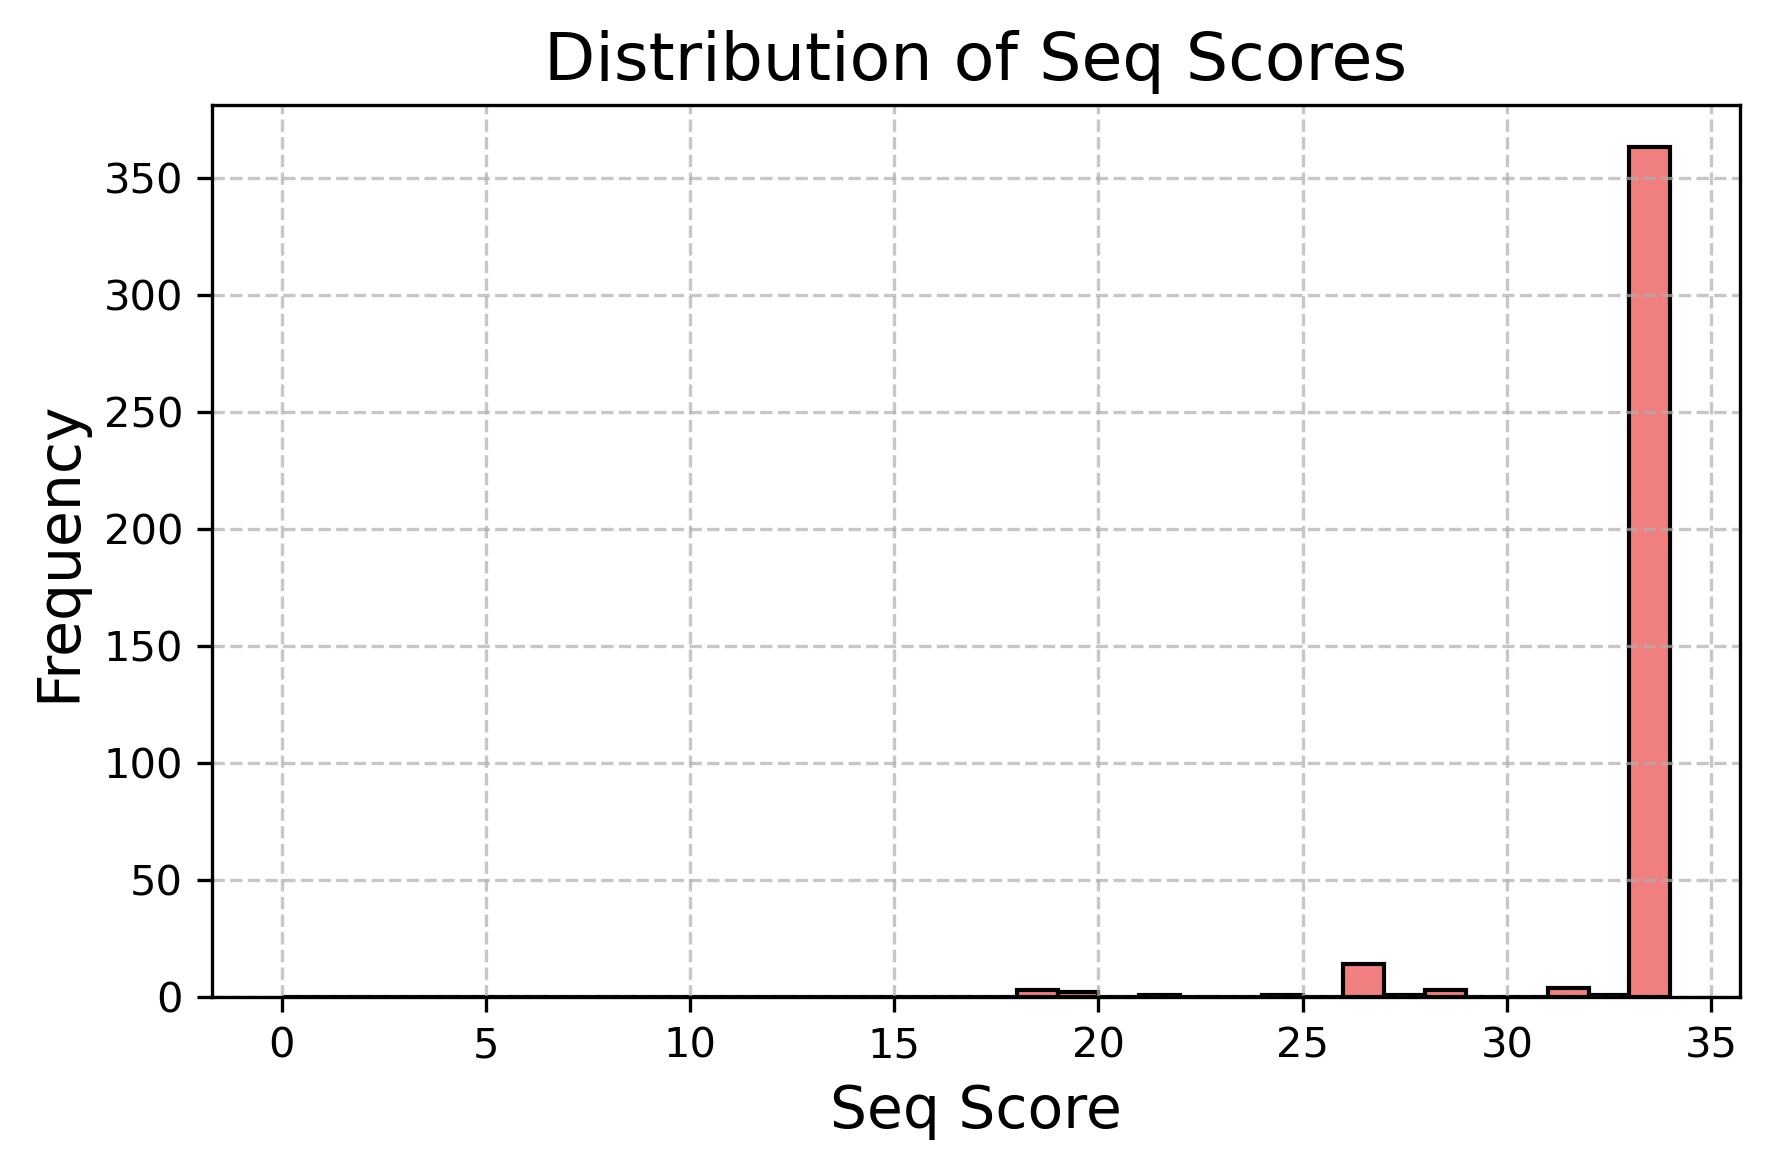

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=300)
plt.hist(df_align['seq_score'], bins=range(0,35,1), color='lightcoral', edgecolor='black')

# 设置标题和标签
plt.title('Distribution of Seq Scores', fontsize=16)
plt.xlabel('Seq Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 添加网格线以提高可读性
plt.grid(True, linestyle='--', alpha=0.7)

# 调整布局以防止重叠
plt.tight_layout()

# 显示图形
plt.show()


In [97]:
df_align_copy = df_align.copy()
df_align_copy['trnseq'] = df_align_copy['seq'].apply(lambda x: x.replace('-', ''))
df_hmmsearch_600_700_copy = df_hmmsearch_600_700.copy()
df_hmmsearch_600_700_copy['trnseq'] = df_hmmsearch_600_700_copy['aliaseq'].apply(lambda x: x.replace('-', ''))
merged_df = pd.merge(df_align_copy, df_hmmsearch_600_700_copy, left_on='trnseq', right_on='trnseq')
merged_df = merged_df.drop_duplicates(['trnseq'])

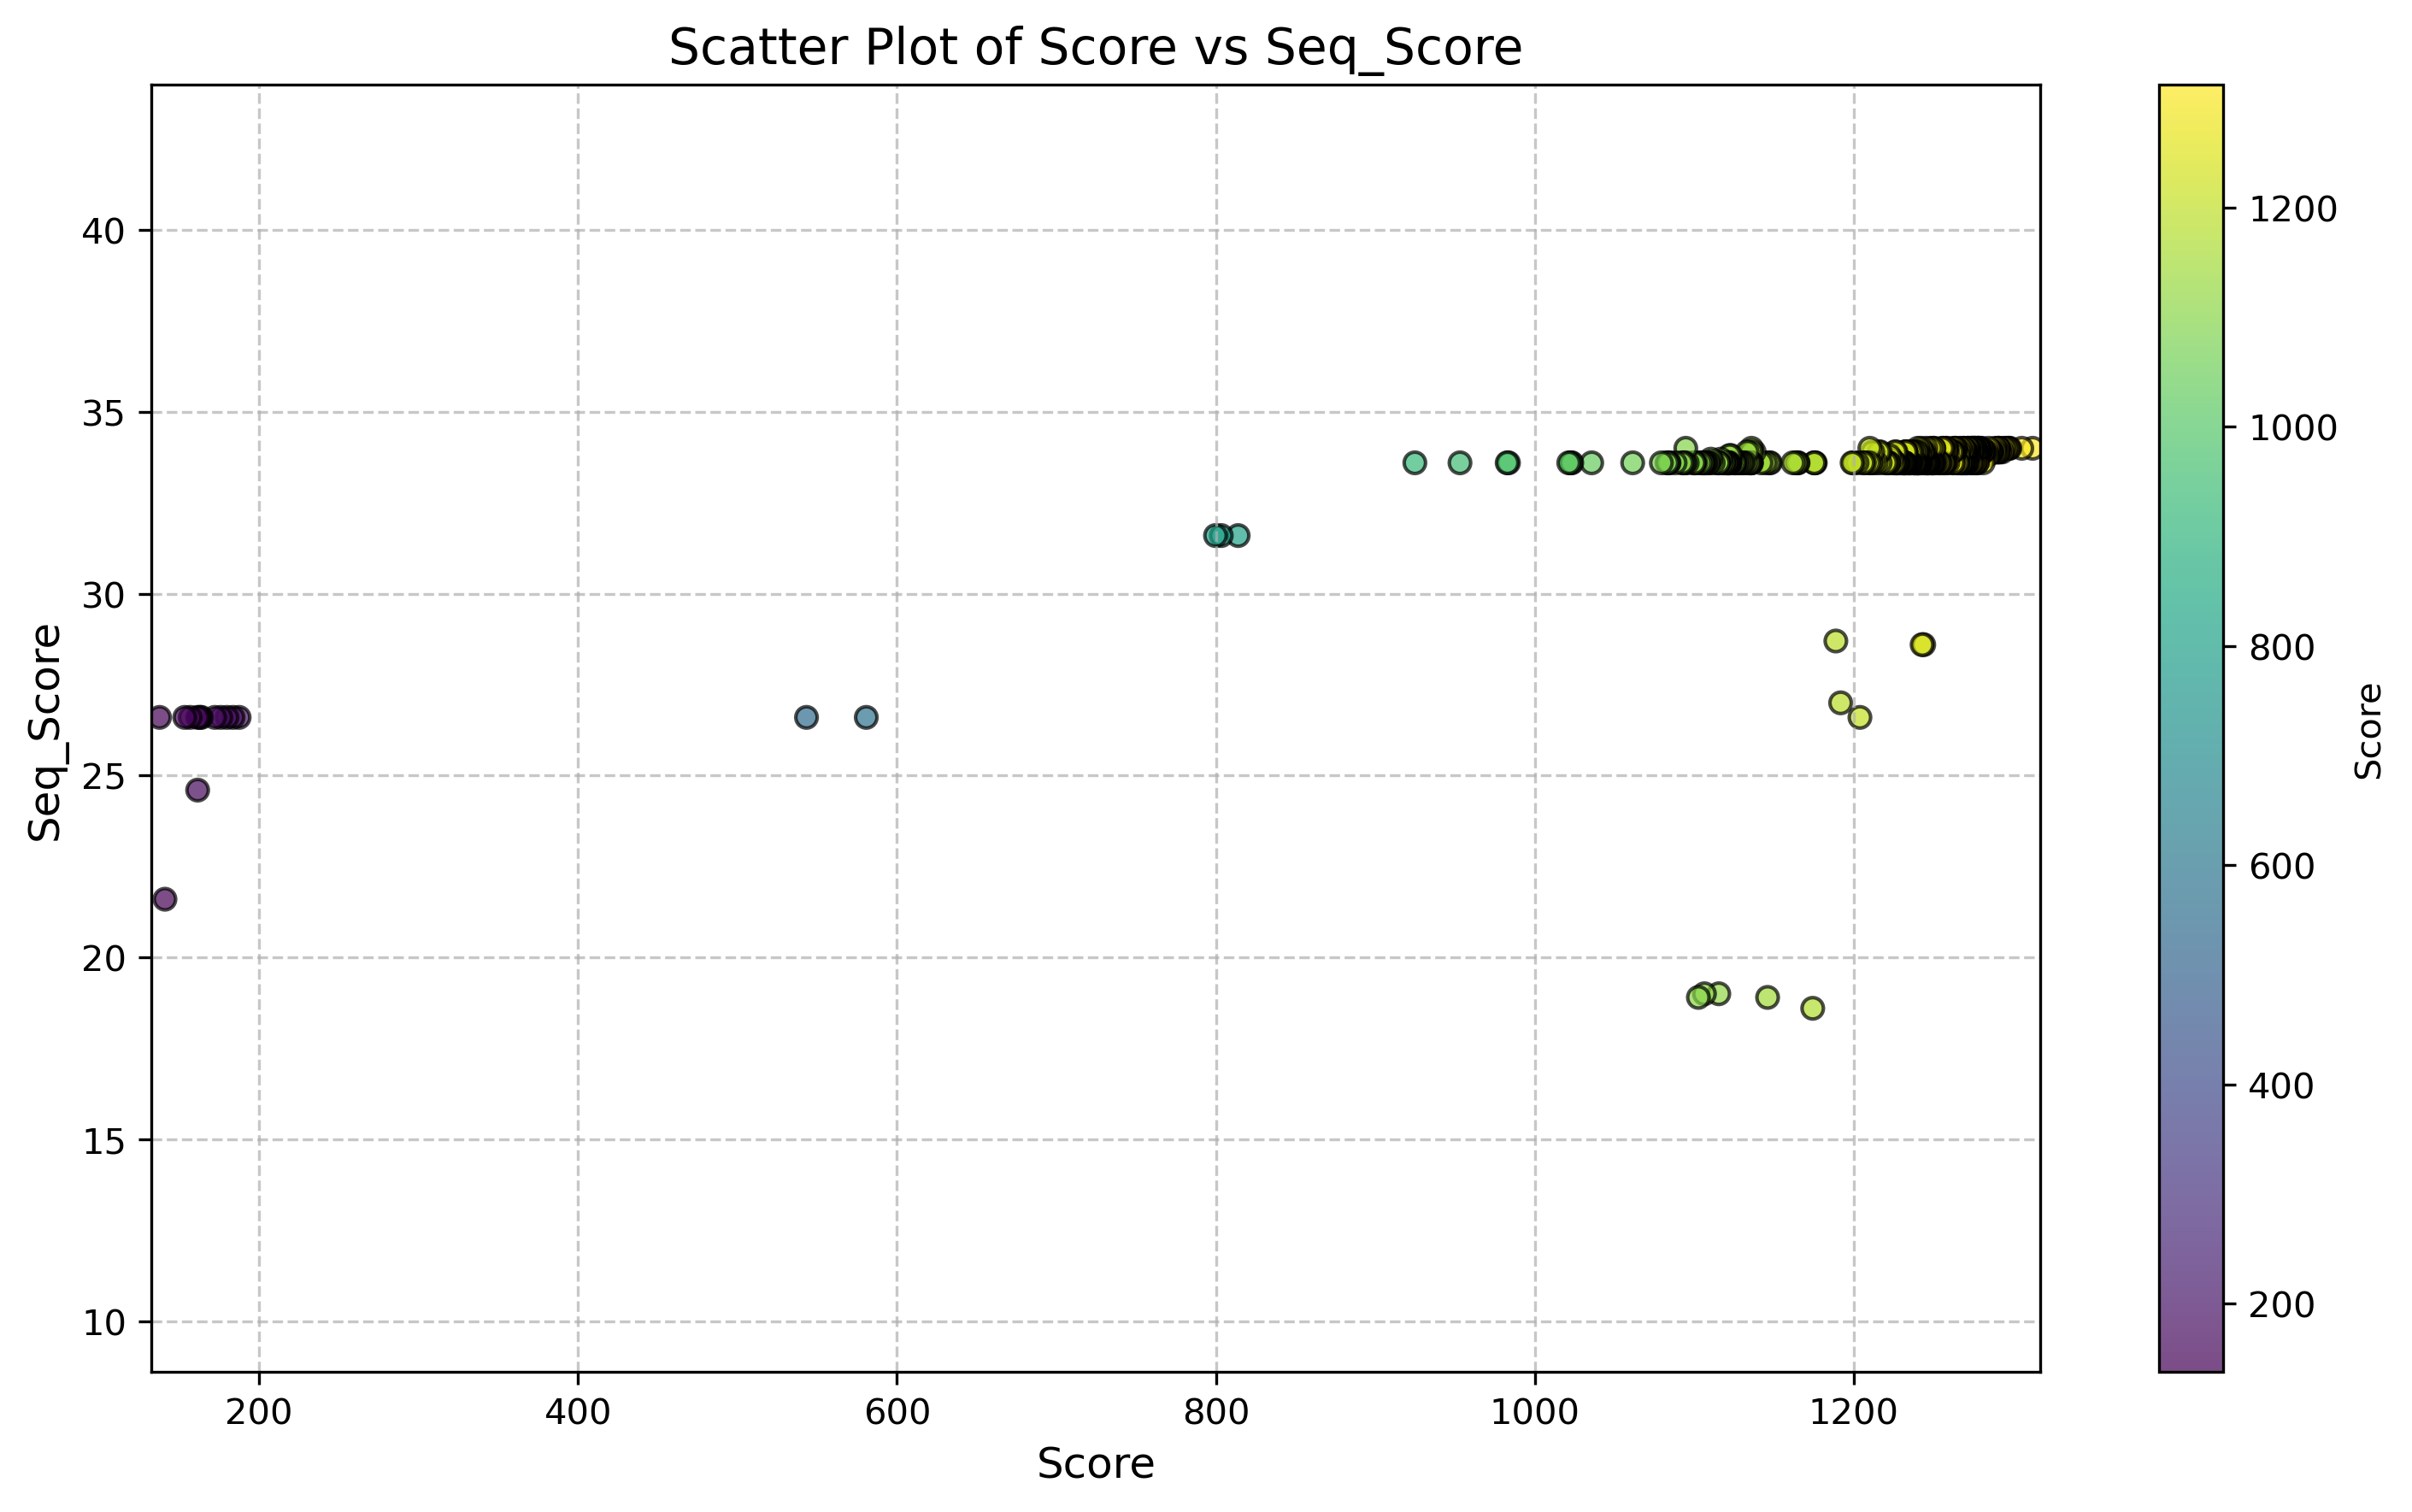

In [101]:
plt.figure(figsize=(10, 6), dpi=300)
scatter = plt.scatter(
    merged_df['score'], 
    merged_df['seq_score'], 
    c=merged_df['score'],  # Color points by score
    cmap='viridis', 
    edgecolor='black', 
    alpha=0.7
)
plt.colorbar(scatter, label="Score")  # Add colorbar for score
plt.title("Scatter Plot of Score vs Seq_Score", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Seq_Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adjust axis limits dynamically
plt.xlim(merged_df['score'].min() - 5, merged_df['score'].max() + 5)
plt.ylim(merged_df['seq_score'].min() - 10, merged_df['seq_score'].max() + 10)

plt.show()

### 3.2 tax_score

In [40]:
ec_organism = pd.read_csv(filenames['brenda_organism'], sep="\t")
ec_organism.head()

,Organism,Commentary,Reference
0,Achatina achatina,-,484921
1,Arion ater,-,484921
2,Arthrobacter globiformis,cf. EC 1.1.3.17,762910
3,Aspergillus ochraceus,-,675045
4,Aspergillus ochraceus,AIU 031,"675045, 688123"


Download the files from the [NCBI Taxonomy ftp](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/) site and preprocessed to obtain the required mapping files.

The preprocess script was the `.\script\process_ncbi_tax.ipynb`. The script only needs to be ran once for the downloaded database, and the cached results can be reused for each evaluation.

In [41]:
# TAXDUMPDIR = "D:\\bioinformatics\\taxdump\\db"
# name2taxid = pd.read_csv(join(TAXDUMPDIR, "name_taxid.tsv"), sep="\t", index_col=0)['tax_id'].to_dict()
# taxid2name = pd.read_csv(join(TAXDUMPDIR, "taxid_name.tsv"), sep="\t", index_col=0)['name_txt'].to_dict()
# taxid2score = pd.read_csv(join(TAXDUMPDIR, "taxid_counts.tsv"), sep="\t", index_col=0)['score'].to_dict()
# taxidrankedlineage = pd.read_csv(join(TAXDUMPDIR, "taxidrankedlineage.tsv"), sep="\t", index_col=0)

Alternatively, a localized database used in the current process is compiled here to support the current script run.

In [42]:
TAXDUMPDIR_L = join(CACHEDIR, "taxdump_db")
name2taxid = pd.read_csv(join(TAXDUMPDIR_L, "name_taxid.tsv"), sep="\t", index_col=0)['tax_id'].to_dict()
taxid2name = pd.read_csv(join(TAXDUMPDIR_L, "taxid_name.tsv"), sep="\t", index_col=0)['name_txt'].to_dict()
taxid2score = pd.read_csv(join(TAXDUMPDIR_L, "taxid_counts.tsv"), sep="\t", index_col=0)['score'].to_dict()
taxidrankedlineage = pd.read_csv(join(TAXDUMPDIR_L, "taxidrankedlineage.tsv"), sep="\t", index_col=0)

In [43]:
def organism2taxid(organism:str):
    o = organism
    taxid, cid, name = -1, 0, ""
    while len(o):
        cid += 1
        if o in name2taxid.keys():
            taxid = name2taxid[o]
            name = taxid2name[taxid]
            break
        o = " ".join(o.split(" ")[:-1])
    return taxid, cid, name

In [44]:
data = []
for org in ec_organism['Organism'].unique():
    taxid, cid, name = organism2taxid(org)
    data.append([org, taxid, cid, name])
df_active_organisms = pd.DataFrame(data, columns=["Organism", "tax_id", "curate_id", "name_txt"])

In [45]:
df_active_organisms.to_csv(join(RESULTDIR, 'active_organisms.tsv'), sep='\t', index=False)
df_active_organisms.head()

,Organism,tax_id,curate_id,name_txt
0,Achatina achatina,1442373,1,Achatina achatina
1,Arion ater,145126,1,Arion ater
2,Arthrobacter globiformis,1665,1,Arthrobacter globiformis
3,Aspergillus ochraceus,40380,1,Aspergillus ochraceus
4,Aspergillus ochraceus AIU 031,40380,3,Aspergillus ochraceus


Compute the tax_score(*tax_id*)

In [46]:
df_active_organisms_taxid = pd.DataFrame(df_active_organisms, columns=['tax_id'])
df_active_organisms_taxid = df_active_organisms_taxid.merge(taxidrankedlineage, left_on='tax_id', right_on='tax_name_tax_id')
active_taxids = df_active_organisms_taxid.stack().value_counts().to_dict()
for key, value in active_taxids.items():
    active_taxids[key] = value * taxid2score[key]

#### Computation of tax_score

Map the sequence to the taxid

In [47]:
known_accessions = set(known_sequences['accession'])

df_align['acc'] = df_align['id'].apply(lambda x: x.split('/')[-2].split('|')[-1])
df_align['active_sequence'] = df_align['acc'].apply(lambda x: x in known_accessions)

# active_sequence: if known(reported by the paper)

In [48]:
# TODO: unify the dealing with '_'
acc2taxid = df_hmmsearch_600_700.set_index('acc')['taxid'].to_dict()
acc2taxid.update({
    key.split('_')[0]: value
        for key, value in acc2taxid.items()
})
# update the known sequences taxid to the dict
active_accession2taxid = known_sequences.set_index('accession')['taxid'].to_dict()
acc2taxid.update(active_accession2taxid)

df_align['taxid'] = df_align['acc'].apply(lambda x: acc2taxid[x] if x in acc2taxid.keys() else acc2taxid[x.split('_')[0]]).astype(int)

In [49]:
df_align_taxid = pd.DataFrame(df_align['taxid'].unique(), columns=['taxid'])
df_align_taxid = df_align_taxid.merge(taxidrankedlineage, left_on='taxid', right_on='tax_name_tax_id')
df_align_taxid['score'] = df_align_taxid.applymap(lambda x: active_taxids[x] if x in active_taxids.keys() else 0).sum(axis=1)

sequence_taxid_score = df_align_taxid.set_index('taxid')['score'].to_dict()
df_align['tax_score'] = df_align['taxid'].map(sequence_taxid_score)
df_align['organism'] = df_align['taxid'].map(taxid2name)

In [50]:
df_align.sort_values(by='tax_score', ascending=False).head(5)

,id,seq,seq_score,acc,active_sequence,taxid,tax_score,organism
9,CAM84032.1/1-664,MAIPDEFDIIVVGGGST----GCCVAGR----------LANLDdQN...,34.0,CAM84032.1,True,870730,3.076742,Ogataea angusta
14,CAM84031.1/1-664,MAIPDEFDIIVVGGGST----GCCVAGR----------LANLDdQN...,32.0,CAM84031.1,True,870730,3.076742,Ogataea angusta
4,CAM84030.1/1-664,MAIPDEFDIIVVGGGST----GCCIAGR----------LANLDdQN...,34.0,CAM84030.1,True,870730,3.076742,Ogataea angusta
6,AAB57849.1/1-663,MAIPEEFDILVLGGGSS----GSCIAGR----------LANLD-HS...,34.0,AAB57849.1,True,4922,2.313146,Komagataella pastoris
19,AAB57850.1/1-663,MAIPEEFDILVLGGGSS----GSCIAGR----------LANLD-HS...,34.0,AAB57850.1,True,4922,2.313146,Komagataella pastoris


### Summary

save the results

In [51]:
df_align[['id', 'acc', 'active_sequence', 'seq_score', 'taxid', 'organism', 'tax_score']].to_csv(
    join(RESULTDIR, "sequence_results.tsv"), 
    sep='\t', index=False
)

The result table can be inspected to select the top ranked sequences for further characterization.

## 4. Diversity

### 4.1 Sequence-based

Construct the sequence similarity networks to select representative sequences.

Pick the sequences with all catalytic and binding sites, and reasonable protein sequences.

In [52]:
df_align_picked = df_align[
    (df_align['seq_score'] >= 33.5) & ~(df_align['seq'].apply(lambda x: 'X' in x))
].copy()


def deal_acc(x:str):
    x = x.split('/')[0]
    x = x.split(' ')[0]
    if '|' in x:
        x = x.split('|')[1]
    return x

df_align_picked['sequence_id'] = df_align_picked['id'].apply(deal_acc)
picked_sequence_id = set(df_align_picked['sequence_id'])

len(df_align_picked) # 360
df_align_picked.to_csv(
    join(RESULTDIR, "sequence_picked_results.tsv"), 
    sep='\t', index=False
)

In [53]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

seqs = []
for seqrecord in SeqIO.parse(join(CACHEDIR, "hmmsearch_600_700_added.fasta"), "fasta"):
    if deal_acc(seqrecord.id) in picked_sequence_id:
        seqs.append(seqrecord)
SeqIO.write(seqs, join(CACHEDIR, "sequence_scored.fasta"), "fasta")
# 360

360

Calculate the similarity between two two sequences using [USEARCH](https://www.drive5.com/usearch/)

In [54]:
print(f"cd {CURRENT_DIR}")

cd d:\Python\aox\enzyme-mining-aox


`D:/bioinformatics/usearch11.0.667_win32.exe -allpairs_global "./data/aox/cache/sequence_scored.fasta" -userout "./data/aox/cache/sequence_scored.userout.tsv" -userfields query+target+id+ql+tl -acceptall`

deal with the results

In [55]:
df_pairwise = pd.read_csv(join(CACHEDIR, "sequence_scored.userout.tsv"), sep='\t', header=None)
df_pairwise.columns = ['query', 'target', 'id', 'ql', 'tl']
df_pairwise['query_sequence_id'] = df_pairwise['query'].apply(deal_acc)
df_pairwise['target_sequence_id'] = df_pairwise['target'].apply(deal_acc)
# 1 - id% as distance.
df_pairwise['distance'] = df_pairwise['id'].apply(lambda x: 1-x*0.01)
df1 = df_pairwise[['query_sequence_id', 'target_sequence_id', 'distance']].copy()
df2 = df_pairwise[['target_sequence_id', 'query_sequence_id', 'distance']].copy()
df2.columns = ['query_sequence_id', 'target_sequence_id', 'distance']
df_distance_matrix = pd.concat([df1, df2]).pivot_table(index='query_sequence_id', columns='target_sequence_id', values='distance', aggfunc='sum').fillna(0)

In [56]:
print(df_distance_matrix.shape)
df_distance_matrix.iloc[:5, :5]

(360, 360)


target_sequence_id,A0A010RMG6,A0A017SR18,A0A060SVX6,A0A066X5A7,A0A067N510
query_sequence_id,,,,,
A0A010RMG6,0.000,0.231,0.486,0.054,0.522
A0A017SR18,0.231,0.000,0.484,0.228,0.509
A0A060SVX6,0.486,0.484,0.000,0.489,0.166
A0A066X5A7,0.054,0.228,0.489,0.000,0.525
A0A067N510,0.522,0.509,0.166,0.525,0.000


The distance matrix could be used in many ways, for example, for clustering, constructing phylogenetic tree or constructing sequence similarity networks(SSN).

#### Cluster

An example of clustering of the sequences to the defined number of clusters.

In [57]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# set the number of clusters
n_clusters = 5


agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
cluster_labels = agg_clustering.fit_predict(df_distance_matrix)

print(len(cluster_labels)) # 360
cluster_counts = np.bincount(np.array(cluster_labels))
print(cluster_counts)

360
[  5  67 122  69  97]


#### Phylogenetic Tree

The visualization is supported by [i-TOL](https://itol.embl.de/).

In [58]:
from scipy.cluster.hierarchy import linkage, to_tree
from scipy.spatial.distance import squareform
import numpy as np

# Use the squareform function to transform the distance matrix into the raw data matrix
df_data_matrix = squareform(df_distance_matrix)

# Calculate the linkage matrix using the linkage function
linkage_matrix = linkage(df_data_matrix, method='ward')

# Convert connection matrices into tree objects
tree = to_tree(linkage_matrix)


def get_newick(node, leaf_names:list, include_distance=True):
    """
    Generate a string in Newick format
    """
    if node.is_leaf():
        return f"{leaf_names[node.id]}" + (f":{node.dist:.6f}" if include_distance else "")
    else:
        left_newick = get_newick(node.left, leaf_names, include_distance)
        right_newick = get_newick(node.right, leaf_names, include_distance)
        return f"({left_newick},{right_newick})" + (f":{node.dist:.6f}" if include_distance else "")

leaf_names = [str(i) for i in range(len(df_distance_matrix))]
newick_tree_with_distance = get_newick(tree, leaf_names, include_distance=True)
newick_tree_without_distance = get_newick(tree, leaf_names, include_distance=False)

# Output a tree in Newick format that includes distance information
print("With Distance Information:")
print(newick_tree_with_distance)

# Output a tree in Newick format that does not include distance information
print("Without Distance Information:")
print(newick_tree_without_distance)


With Distance Information:
(((61:0.000000,(242:0.000000,(8:0.000000,17:0.000000):0.094000):0.151067):0.264920,(((219:0.000000,((338:0.000000,(64:0.000000,114:0.000000):0.062000):0.071638,((307:0.000000,(63:0.000000,136:0.000000):0.077000):0.087180,(191:0.000000,312:0.000000):0.094000):0.105540):0.119566):0.168815,(((100:0.000000,(2:0.000000,119:0.000000):0.038000):0.073207,((173:0.000000,234:0.000000):0.014000,(132:0.000000,(209:0.000000,331:0.000000):0.000000):0.099304):0.106429):0.122762,((210:0.000000,212:0.000000):0.074000,(18:0.000000,(285:0.000000,309:0.000000):0.077000):0.087504):0.127665):0.220829):0.266567,((((67:0.000000,236:0.000000):0.057000,(345:0.000000,(221:0.000000,(220:0.000000,230:0.000000):0.043000):0.096594):0.102802):0.261416,(((77:0.000000,88:0.000000):0.014000,(4:0.000000,(((337:0.000000,359:0.000000):0.000000,(65:0.000000,233:0.000000):0.062000):0.085697,(171:0.000000,(5:0.000000,(237:0.000000,292:0.000000):0.123000):0.144593):0.157110):0.175703):0.192126):0.207

In [59]:
# save the tree and annotations.
ITOL_DIR = join(DATADIR, "graph", "itol")

with open(join(ITOL_DIR, "sequence_scored.with_distance.newick"), "w") as f:
    f.write(newick_tree_with_distance)
with open(join(ITOL_DIR, "sequence_scored.without_distance.newick"), "w") as f:
    f.write(newick_tree_without_distance)
pd.DataFrame(df_distance_matrix.index).to_csv(join(CACHEDIR, "sequence_scored.index.tsv"), index=False, header=False)

Please refer to the `4-itol-visualization.ipynb` for more about the annotation of the tree.

#### Sequence Similarity Network

The Visualization was supported by [CytoScape](https://cytoscape.org/).

In [60]:
SSN_DIR = join(DATADIR, "graph", "acc")

df_pairwise_ssn = df_pairwise[['query', 'target', 'id']].copy()
df_pairwise_ssn['query'] = df_pairwise_ssn['query'].apply(deal_acc)
df_pairwise_ssn['target'] = df_pairwise_ssn['target'].apply(deal_acc)
df_pairwise_ssn = df_pairwise_ssn[['query', 'target', 'id']]
df_pairwise_ssn.to_csv(join(SSN_DIR, "edges.tsv"), sep='\t')

In [61]:
df_nodes = pd.DataFrame(list(df_distance_matrix.index), columns=['accession'])
print(len(df_nodes))
df_nodes = df_nodes.merge(df_align_picked[['sequence_id', 'active_sequence', 'taxid']], left_on='accession', right_on='sequence_id')
df_nodes = df_nodes.merge(df_align_taxid[['taxid', 'class_tax_id', 'phylum_tax_id', 'score']])
df_nodes['class'] = df_nodes['class_tax_id'].apply(lambda x: taxid2name[x])
df_nodes['phylum'] = df_nodes['phylum_tax_id'].apply(lambda x: taxid2name[x])
df_nodes['active_tax'] = df_nodes['score'].apply(lambda x: x > 0.01)
print(len(df_nodes)) # 358? lost 2?
df_nodes.head(5)


360
358


,accession,sequence_id,active_sequence,taxid,class_tax_id,phylum_tax_id,score,class,phylum,active_tax
0,A0A010RMG6,A0A010RMG6,False,1445577,147550,4890,0.000250,Sordariomycetes,Ascomycota,False
1,A0A017SR18,A0A017SR18,False,1388766,147545,4890,0.000967,Eurotiomycetes,Ascomycota,False
2,A0A060SVX6,A0A060SVX6,False,5643,155619,5204,0.000816,Agaricomycetes,Basidiomycota,False
3,A0A066X5A7,A0A066X5A7,False,1173701,147550,4890,0.000250,Sordariomycetes,Ascomycota,False
4,A0A067N510,A0A067N510,False,1137138,155619,5204,0.000219,Agaricomycetes,Basidiomycota,False


In [62]:
df_nodes[['accession', 'class', 'phylum', 'active_sequence', 'active_tax', 'score']].to_csv(join(SSN_DIR, 'nodes.tsv'), sep='\t')

Please refer to the `3-ssn-visualization.ipynb` for more about the SSN.

### 4.2 Structure Similarity

Predict the structure using the SWISS-MODEL server.

In [63]:
PREDDIR = join(DATADIR, "pred")

# Prepare the enzymes DataFrame for the function query_enzyme()
enzymes = df_align_picked[['acc', 'seq']].copy()
enzymes['trnc_seq'] = enzymes['seq'].str.replace("-","")
enzymes = enzymes.reset_index().drop(columns=['index', 'seq'])
enzymes.columns = ['Name', 'Sequence']
enzymes.head(5)

,Name,Sequence
0,AAV66466.1,MAIPDEFDIIVVGGGSTGCALAGRLGNLDENLTVALIEGGENNINN...
1,AAF02494.1,MAIPDEFDIIVVGGGSTGCALAGRLGNLDENVTVALIEGGENNINN...
2,AAV66465.1,MAIPDEFDIIVVGGGSTGCAIAGRLGNLDENLTVALIEGGENNINN...
3,AAF02495.1,MAIPEEFDIIVVGGGSAGCPTAGRLANLDPNLTVALIEAGENNINN...
4,CAM84030.1,MAIPDEFDIIVVGGGSTGCCIAGRLANLDdQNLTVALIEGGENNIN...


In [64]:
from script.swiss_model import log_main, query_enzymes

# log_main(True)
# query_enzymes(enzymes, pdbdir=join(PREDDIR, 'pdb'), verbose=True)

*The prediction results of structures were not uploaded due to the large size of the structure file. Here, structure prediction can be realized using other tools such as AlphaFold, ESMFold, etc.*

In [65]:
# enzymes.head(5)

In [66]:
# query_enzymes(enzymes, pdbdir=join(PREDDIR, 'pdb'), verbose=True)

In [67]:
# enzymes.to_csv(join(PREDDIR, 'enzymes.tsv'), sep="\t")

[TM-align](https://zhanggroup.org/TM-align/) for a 1-vs-1 structural alignment.

`cd /mnt/d/python/aox/enzyme-mining-aox/data/aox/pred`

`chmod +x run_tmalign.sh`

`./run_tmalign.sh`

Deal with TM-align results.

In [68]:
def extract_tm_score(file_path):
    with open(file_path, 'r') as file:
        file_content = file.read()

    # Finding the start and end of the TM-score
    tm_score_start = file_content.find("TM-score=")
    if tm_score_start != -1:
        tm_score_end = file_content.find(" (if normalized by length of Chain_1)", tm_score_start)
        if tm_score_end != -1:
            # Extract TM-score values
            tm_score_value = file_content[tm_score_start + len("TM-score="):tm_score_end].strip()
            return tm_score_value
        else:
            return None  # TM-score end not found
    else:
        return None  # TM-score start not found

# An example
file_path = join(PREDDIR, "align", "0_1.align.txt")
tm_score = extract_tm_score(file_path)
if tm_score is not None:
    print(f"Extracted TM-score: {tm_score}")
else:
    print("TM-score not found in the file.")

Extracted TM-score: 0.99992


*The results of the alignment were not uploaded due to its large size.*

In [69]:
data = []

folder_path = join(PREDDIR, "align")
for filename in os.listdir(folder_path):
    if filename.endswith(".align.txt"):
        i, j = filename.split(".")[0].split("_")
        i, j = int(i), int(j)

        score = extract_tm_score(os.path.join(folder_path, filename))

        data.append([i, j, score])

In [70]:
df_structure_sim = pd.DataFrame(data)
df_structure_sim.columns = ['i', 'j', 'tmscore']
df_structure_sim['tmscore'] = df_structure_sim['tmscore'].astype(float)

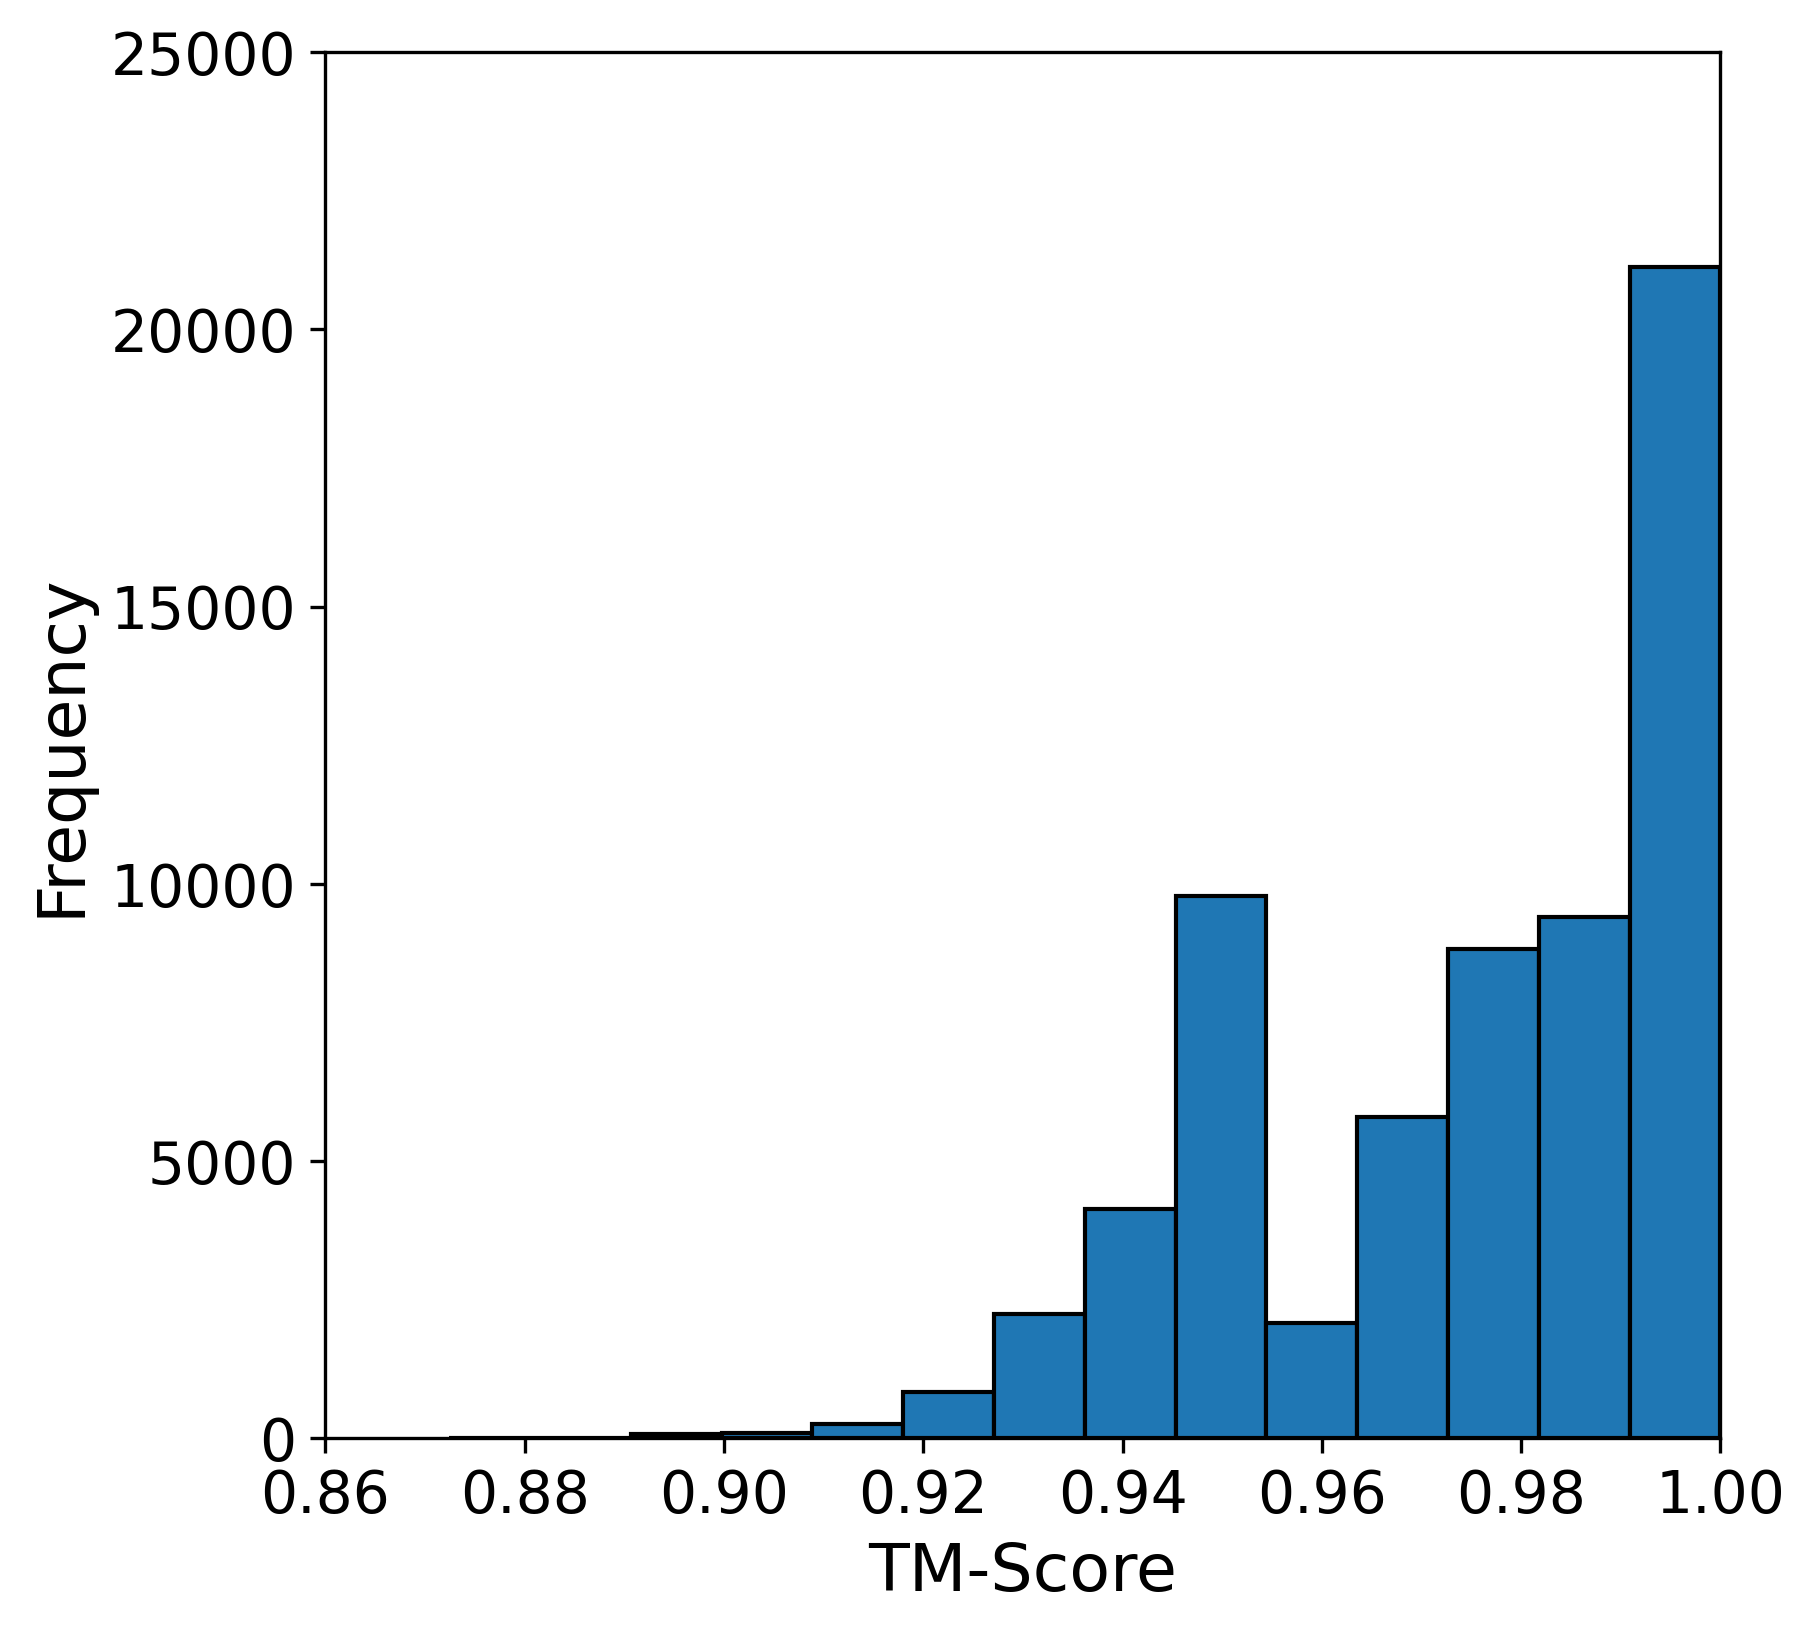

In [71]:
import matplotlib.pyplot as plt
import numpy as np

tmscore_list = df_structure_sim['tmscore'].to_list()

plt.figure(figsize=(6, 6), dpi=300)

bins = int((1.00 - 0.86) / 0.01)
plt.hist(tmscore_list, bins=bins, edgecolor='black')

plt.xlim(0.86, 1.00)
plt.ylim(0, 25000)
plt.xticks(np.arange(0.86, 1.0, 0.02), fontsize=14)
plt.yticks(np.arange(0, 25001, 5000), fontsize=14)

plt.xlabel('TM-Score', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.show()